# <center>Characterization of pilot-based distributed executions on the<br>XSEDE OSG Virtual Cluster</center>

## Abstract

## Introduction

XSEDE offers multiple resources that support diverse types of computing: high performance~\cite{}, data intense~\cite{}, cloud~\cite{}, and grid~\cite{}. Users can execute their domain-specific applications on any of these resources, depending on the computing requirements of applications. A growing number of scientific applications executes workflows that can benefit from the concurrent use of multiple types of computing, depending on whether they require single and multiple cores; small and large amount of data; or communication and coordination before, during and after runtime. For example, workflows that have multiple stages, possibly organized in concurrent pipelines, may use asynchronous communication and coordination while requiring both multi and single-core executions. These workflows are particularly common in applications that simulate and analyze the dynamic properties of molecular interactions (MD workflows)~\cite{} or those used to \ldots \mtnote{Make this more general adding examples}~\cite{}.

Concurrent executions across diverse types of resources have the potential to improve the time to completion (TTC) of workflows with heterogeneous tasks. Each type of resources can better serve subsets of the workflow's tasks by offering specific capabilities, software environment, or distinct utilization patterns. Executions performed on a single machine or multiple machines with the same capabilities cannot benefit from these specificities, resulting in a less efficient overall execution. Nonetheless, concurrent executions across diverse types of resources present both conceptual and technological challenges: (i) understanding how the capabilities of specific architectures and software environment can satisfy the requirements of workflow's tasks; (ii) enabling interoperability and coordination across the distributed execution process by abstracting differences among resources; and (iii) developing specific technologies to evaluate the workflow requirements, acquire suitable resources, and plan, enact and manage its distributed execution. 

In this paper, we contribute to address these challenges by studying how resource dynamism and heterogeneity affects the TTC of workflows. Specifically, we perform experiments on the XSEDE OSG Virtual Cluster (XOVC) by performing distributed and concurrent execution of a representative set of tasks of a real-life MD workflow. The resources of the XOVC are dynamic because their capabilities and availability can change over time, including during the execution of the workflow. Resources can be available, unavailable, or perform differently depending, for example, on resource-defined policies, load, supporting middleware or fault. Resources are heterogeneous because of different architectures, geographical locations, or software environment. The XOVC resources can: (i) have different CPU, memory, storage or networking architectures; (ii) have single or clustered components; (iii) be grouped into a lab, data center or dislocated across campus locations; (iv) offer direct access to the operating system, use queues of a batch system, or mono- and multi-tenant resource containers and overlays.

The execution model of applications on XOVC is assumed to take into account both resource dynamisms and heterogeneities. This is supported with policies and software tools: applications are assumed not to require more than one core per task and it is suggested to limit the runtime of each task to twelve hours~\cite{}. Task execution can be suspended or terminated at any point in time so task checkpointing or, more commonly~\cite{}, rescheduling is assumed. More in general, a certain amount of execution failure is not excluded, due to unassured resource availability but also incompatible execution environment. The heterogeneity of software stack on the resources implies non uniform availability of compilers, library, or executables. Applications are therefore assumed to take care of setting up a suitable execution environment.

We focus on use cases that may benefit from distributed and concurrent execution across diverse types of resources. We use a pilot-enabled, interoperable and integrated middleware, supporting a uniform execution model not only on the resources of XOVN but also on XSEDE HPC and cloud resources~\cite{}. This middleware enables the instantiation of pilots on, for example, XOVC, Stampede, Maverick or Bridges and the concurrent execution of a workflow's tasks on all those pilots as soon as they become available. Tasks can be executed concurrently and sequentially on each pilot depending on the number of cores available, and multiple pilots can be instantiated at the same time on one resorce and on multiple resources. We used this middleware to submit multiple single-core jobs to XOVC, each job bootstrapping a pilot agent capable of sequentially executing single-core tasks for up to twelve hours.

Our experimental workflow emulated the concurrent execution of multiple MD simulations, i.e., a 'workload'. Each task of the workload emulates a specific execution of AMBER, a software package that simulates force fields for the dynamics of biomolecules. We measured the parameters of our emulation by profiling the execution of an AMBER simulation that is part of a real-life use case, investigating novel computational methods to sample relevant regions on the potential energy surface of macromolecular systems. These methods benefit from increasingly large workloads as part of a more heterogeneous workflow where each task is performed on a single core: the larger the workload, the longer and more accurate the simulation of the molecular dynamic. Distributing the execution of this type of workload across multiple resources represent a viable path to scalability that does not rely on the availability of increasingly large single-clustered machines but makes use of the increasingly large number of resources already deployed.

In this context, a characterization of XOVC enables understanding the trade offs of distributing the execution of the given workload over available XSEDE resources to improve the TTC of the considered use case. For our characterization, we use the AIMES integrated middleware, a software system we developed to support both experimental and production distributed executions over multiple and diverse resources. The AIMES middleware is designed and implemented as a set of independent software components that can be used both individually or as an integrated system. Once integrated, the AIMES middleware enables the specification of a workload, the use of a profile-based executable emulator, the derivation of an execution strategy for the execution of the specified workload on a set of available resources, and the enactment of this strategy via a pilot system called RADICAL-Pilot and a resource-level interoperability API called RADICAL-SAGA.

We performed 9 distinct experiments with 360 independent workload executions across 13 months, for a total of 262208 single-core emulations successfully executed on XOVC. Our analysis showed: \ldots~\mtnote{summary of contributions.}

This paper has five sections:\ldots~\mtnote{Brief summary of the sections of the paper.}

## Related Work

* What is campus bridging and what is XSEDE doing about it?
* XSEDE campus bridging use cases
* Comparing Futuregrid, amazon ec2, and open science grid for scientific workflows
* Job and data clustering for aggregate use of multiple production cyberinfrastructures
* A Comparison of a Campus Cluster and Open Science Grid Platforms for Protein-Guided Assembly using Pegasus Workflow Management System
* Leveraging the national cyberinfrastructure for biomedical research
* Distributed application runtime environment (DARE): a standards-based middleware framework for science-gateways

## Tools and Methods

The characterization of the dynamics and heterogeneities of XOVC depends on tailored tools and experimental methodologies. We developed the AIMES Middleware as a set of modules that enable the distributed execution of scientific workloads on diverse computing infrastructures. These modules are: Skeleton to succintely describe scientific applications; Synapse to profile and emulate the execution of those applications; Emanager to derive and enact strategies for the distributed execution of applications' workload; RADICAL-Pilot to describe workload tasks and pilots and to manage the execution of the former on the latter; and RADICAL-SAGA to enable the submission of pilots to diverse types of resource, e.g., clusters, grids, or clouds. Each module has a well-defined set of capabilities; can be used independently from the AIMES middleware; does not impose a specific language to specify application workloads; and requires no installation of dedicated software on the resources on which workloads are executed. The AIMES middleware can aggregate all or some of these modules, depending on the use case and the type of execution that needs to be performed.

In this paper, we integrated all modules of the AIMES middleware to emulate the workload of our use case at different scales. <!-- We emulated workload with different amount of tasks and with tasks requiring different amount of FLOPS. --> The AIMES middleware enabled the timestamping of each state transition of both the workload and the resources on which the workload was distributed and executed. These timestamps were used to qualify and measure the dynamics of XOVC by calculating when and for how long each resource was available or unavailable, and when and for how long each task was waiting to be executed or being executed. 

Developing these tools and methodology posed several challenges: timestamps need to be concurrently recorded as tasks can be executed with a varying degree of concurrency and on diverse resources; timestamps need to be synchronized to account for the time variations across indepdendent resources; state transitions need to be explicitly defined and guaranteed to be ordered on a sequence over time to enable measuring of the time components of the overall execution time; and information about properties of both tasks and resources needs to be collected so to enable the analysis of task binding to hosts, hosts' capabilities, and, possibly, hosts' name and location.

The characterization of the heterogeneity of XOVC required measuring differences in performance across resources. We used the Synapse emulator to differentiate between CPU and filesystem performances. CPU performance can be measured in multiple ways~\cite{} but the scientific workload of our use case is dominated by floating-point calculations~\cite{}. Accourdingly, we measured CPU performance in terms of floating-point operations per second (FLOPS). We cannot directly access and measure the CPU FLOPS of each resource so we developed a tool to: (a) define a fixed amount of FLOPS; (b) emulate the pattern of FLOPS utilization of the scientific application of our use case;  and (c) measure the time taken by each resource to perform the indicated amount of FLOPS. We considered this timespan a function of the CPU capabilities of the resources, and comparison among resources' timespans an indirect measure of CPU performance heterogeneity.

\mtnote{Description of filesystem performance measurements}

### Synapse

We use Synapse to profile and then emulate a specific instance of the AMBER application, a software package that simulates force fields for the dynamics of biomolecules. We correlate the time taken to compute a certain amount of FLOPS to the speed of the processor on which this computation is performed. We are not able to perform emulation in protected mode and directly on the processor, therefore a certain amount of architectural and software overhead is to be expected. Further, any concurrent system load influences both executed and emulated simulation performance. For this reason, we need to consider both the consistency and the accuracy of the timings we collect with Synapse.

We consider the profile of an execution of an application to be accurate when the profiling measures the effective number of flops performed by that application. The profile is consistent when multiple instances of profiling returns the same amount of flops for the same execution. Analogously, we consider an emulation of the profiled execution to be accurate when the time taken by the application to compute that number of flops on a given machine is the same time as taken by our emulator on that same machine. An emulation is consistent when multiple runs of the same emulation on the same machine require the same amount of time.

We used Synapse to profile and then emulate a specific AMBER simulation as parametrized and executed by our use case. We performed n experiments, measuring both the accuracy and consistency of our profiling and emulation to validate the use of Synapse to characterize the dynamism and heterogeneity of XOVC. Specifically, we have to verify that executing our emulation multiple times on the same resource of XOVC yelds analogous execution times. Furthermore we  also have to verify that the delta in execution time of the AMBER simulation between two resources should be analogous to the delta in execution time of our emulation on those two resources.

We executed our experiments on two machine: a reference and a secondary machine. The reference machine is a 8-core server with i7-3770 CPUs (3.7GHz) and 32GB of RAM. The machine is in concurrent use by several users, introducing noise in the system load, consistent with the expected execution environment of the XOVC resources. The secondary machine is a laptop with a 2-cores 2.3 GHz Intel Core i7 and 16GB of RAM, on which suitable system loads is executed to create analogous amount of noise.

#### Baseline

We measured the time taken by the chosen AMBER simulation to be executed on our reference machine. The outliers are considered to be caused by sporadic system overload.

Load python modules and some helper functions.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

Load csv files with baseline data

In [3]:
baseline = pd.read_csv('../../synapse_characterization/sander_run_radical/sander_run_radical.csv', 
                       header=None, 
                       usecols=[3],
                       names = ['TTC'])

Plot frequency distribution of TTC for AMBER emulation execution

NormaltestResult(statistic=60.126844981229823, pvalue=8.7825676794694221e-14)

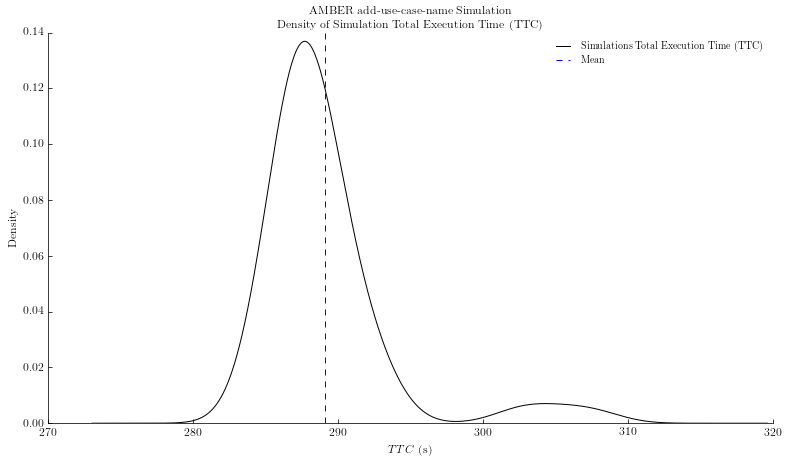

In [4]:
fig, ax = fig_setup()
title='AMBER add-use-case-name Simulation\nDensity of Simulation Total Execution Time (TTC)'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(baseline['TTC'].dropna().tolist()))
baseline[['TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)
plt.axvline(baseline['TTC'].dropna().mean(), color='b', linestyle='dashed', linewidth=1)

ax.set_xlabel('$TTC$ (s)')
ax.legend(labels=['Simulations Total Execution Time (TTC)', 'Mean'])

# plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

#### Profiler Accuracy

It depends on *perf* command.

#### Profiler Consistency

We expect the Synapse Profiler to have comparable noise in measured runtime as the actual execution. Also, the profiler is expected to have little (if any) impact on the runtime of the application running under the profiler. We observe fewer outliers, and thus also a smaller standard deviation. The means are comparable as expected.

Load csv files with profiler data

In [5]:
profiler = pd.read_csv('../../synapse_characterization/sander_profile_radical/sander_profile_radical.csv', 
                       header=None, 
                       usecols=[3,4],
                       names = ['Profiled TTC','Number of FLOPS'])

Plot frequency distribution of profiled TTC for AMBER emulation execution

NormaltestResult(statistic=22.69442682271173, pvalue=1.1802332089034594e-05)

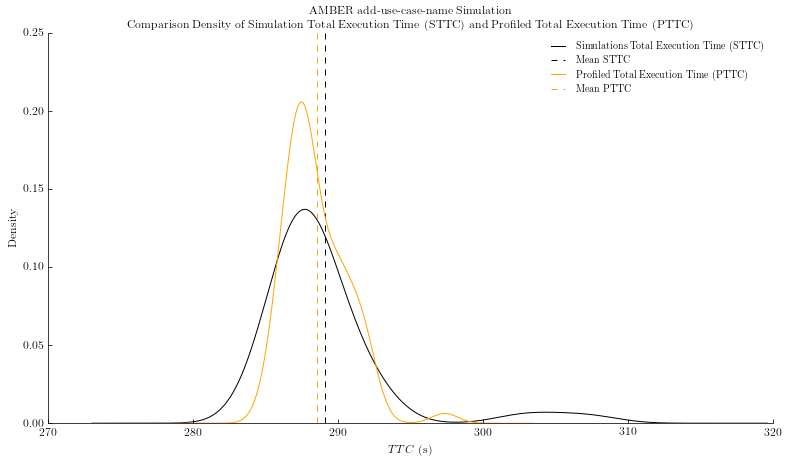

In [6]:
fig, ax = fig_setup()
title='AMBER add-use-case-name Simulation\nComparison Density of Simulation Total Execution Time (STTC) and Profiled Total Execution Time (PTTC)'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(profiler['Profiled TTC'].dropna().tolist()))
baseline[['TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)
plt.axvline(baseline['TTC'].dropna().mean(), color='black', linestyle='dashed', linewidth=1)
profiler[['Profiled TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='orange', title=title)
plt.axvline(profiler['Profiled TTC'].dropna().mean(), color='orange', linestyle='dashed', linewidth=1)

ax.set_xlabel('$TTC$ (s)')
ax.legend(labels=['Simulations Total Execution Time (STTC)', 'Mean STTC',
                  'Profiled Total Execution Time (PTTC)', 'Mean PTTC'])

# plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

The Synapse Profiler is also expected to measure a consistent number of flops for each execution. While the standard deviation is about 2% of the mean value for the execution times, it is about 7.5% for the measured number of flops, so spreads somewhat wider as expected. Ref.~\cite{synapse.paper} discusses this variance in flop measurements in some detail.

NormaltestResult(statistic=13.782308282952041, pvalue=0.0010167397021040604)

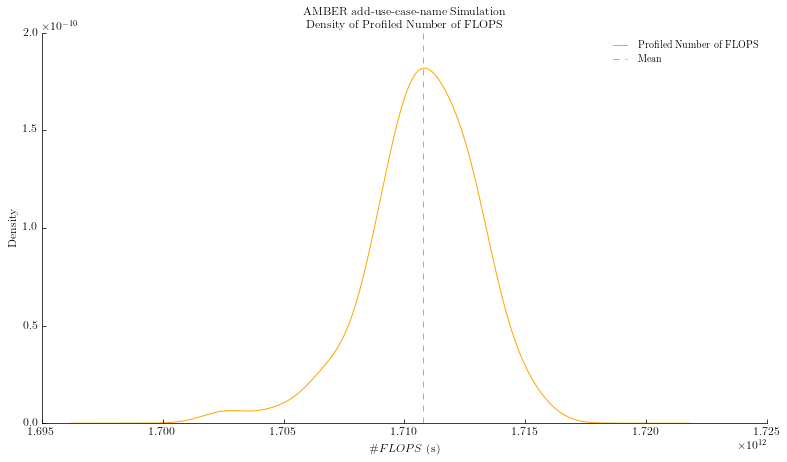

In [7]:
fig, ax = fig_setup()
title='AMBER add-use-case-name Simulation\nDensity of Profiled Number of FLOPS'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(profiler['Number of FLOPS'].dropna().tolist()))
profiler[['Number of FLOPS']].dropna().reset_index(drop=True).plot.density(ax=ax, color='orange', title=title)
plt.axvline(profiler['Number of FLOPS'].dropna().mean(), color='orange', linestyle='dashed', linewidth=1)

ax.set_xlabel('$\#FLOPS$ (s)')
ax.legend(labels=['Profiled Number of FLOPS', 'Mean'])

#### Emulation Accuracy

When emulating the workload profiled in experiment 2, we expect that repeated emulation runs for the same profile results in comparable runtimes. We motivated above why I/O operations are excluded from the emulation runs (but see experiment 5 below!), so the execution times are not expected to be exactly the same as seen in experiment 1 (excution of simulation), but we do expect a comparable distribution. The amount of flops emulated in this experiment is the average of flops measured in experiment 2. Ignoring the I/O operations results in alower overall execution time, as one would expect. The observed standard deviation is comparable to the actual execution times from experiment 1.

Load csv files with emulator data

In [8]:
emulation_mean = pd.read_csv('../../synapse_characterization/sample_mean_flops_radical/sander_emulate_meanflops_radical.csv', 
                             header=None, 
                             usecols=[3],
                             names = ['Emulated TTC'])

Plot frequency distribution of emulated TTC for AMBER emulation execution

NormaltestResult(statistic=10.747893904038325, pvalue=0.0046357978816926985)

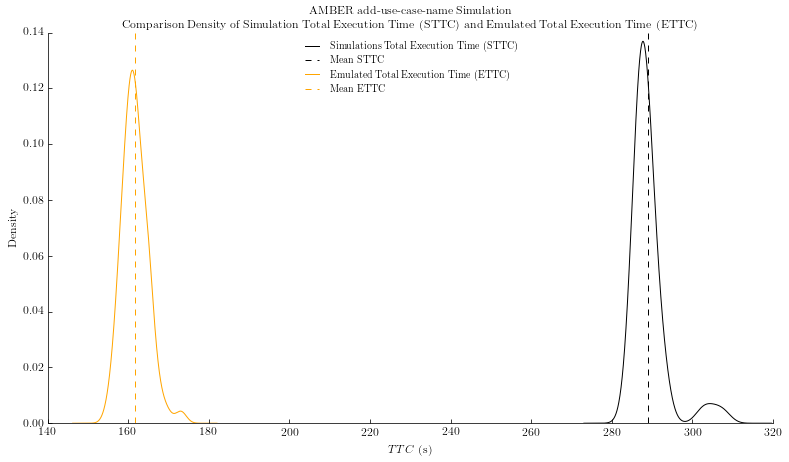

In [9]:
fig, ax = fig_setup()
title='AMBER add-use-case-name Simulation\nComparison Density of Simulation Total Execution Time (STTC) and Emulated Total Execution Time (ETTC)'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(emulation_mean['Emulated TTC'].dropna().tolist()))
baseline[['TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)
plt.axvline(baseline['TTC'].dropna().mean(), color='black', linestyle='dashed', linewidth=1)
emulation_mean[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='orange', title=title)
plt.axvline(emulation_mean['Emulated TTC'].dropna().mean(), color='orange', linestyle='dashed', linewidth=1)

ax.set_xlabel('$TTC$ (s)')
ax.legend(labels=['Simulations Total Execution Time (STTC)', 'Mean STTC',
                  'Emulated Total Execution Time (ETTC)', 'Mean ETTC'],
          loc='upper center')

# plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

#### Emulation Consistency

To ensure that the results of experiment 3 are not a fluke for this specific flop number, we also measure the emulation for the individual profiled flop numbers from experiment 2. We expect the resulting distribution to have a somewhat larger standard deviation, as we are folding several statistical distributions (execution, profiling and emulation) into one measurement. This is indeed the case -- but the distribition mean remains consistent with experiment 3, and the standard deviation is not growing beyond what one would naively expect.

Load csv files with emulator data

In [10]:
emulation = pd.read_csv('../../synapse_characterization/sample_flops_radical/sander_emulate_flops_radical.csv', 
                        header=None, 
                        usecols=[3],
                        names = ['Emulated TTC'])

Plot frequency distribution of emulated TTC for AMBER emulation execution

NormaltestResult(statistic=9.6780730006622591, pvalue=0.007914676166917033)

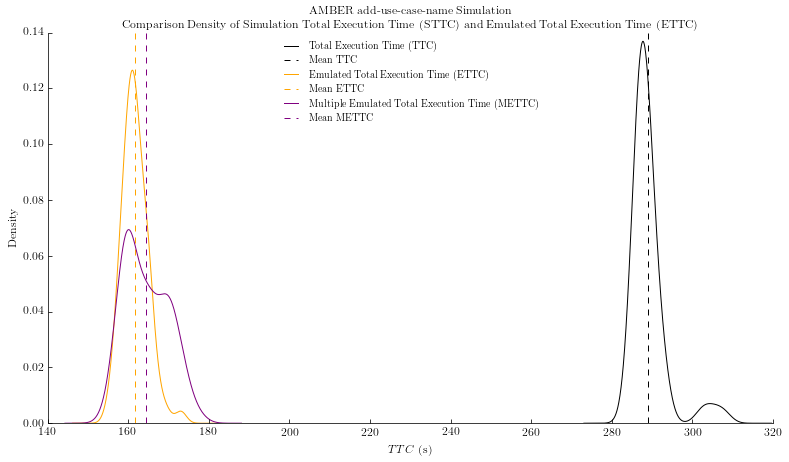

In [11]:
fig, ax = fig_setup()
title='AMBER add-use-case-name Simulation\nComparison Density of Simulation Total Execution Time (STTC) and Emulated Total Execution Time (ETTC)'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(emulation['Emulated TTC'].dropna().tolist()))

baseline[['TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)
plt.axvline(baseline['TTC'].dropna().mean(), color='black', linestyle='dashed', linewidth=1)
emulation_mean[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='orange', title=title)
plt.axvline(emulation_mean['Emulated TTC'].dropna().mean(), color='orange', linestyle='dashed', linewidth=1)
emulation[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='purple', title=title)
plt.axvline(emulation['Emulated TTC'].dropna().mean(), color='purple', linestyle='dashed', linewidth=1)

ax.set_xlabel('$TTC$ (s)')
ax.legend(labels=['Total Execution Time (TTC)', 'Mean TTC',
                  'Emulated Total Execution Time (ETTC)', 'Mean ETTC',
                  'Multiple Emulated Total Execution Time (METTC)', 'Mean METTC'],
          loc='upper center')

# plt.savefig('figures/synapse_all.pdf', dpi=600, bbox_inches='tight')

Unrelated to this specific paper, we also performed the same experiment as (4), but now included I/O emulation (disk and memory). We expect the mean runtime to be closer to what we measured as actual simulation runtime in experiment 1.

In [12]:
emulation_prof = pd.read_csv('../../synapse_characterization/sample_profiles_radical/sander_emulate_profiles_radical.csv', 
                             header=None, 
                             usecols=[3],
                             names = ['Emulated TTC'])

Plot frequency distribution of emulated TTC for AMBER emulation execution

NormaltestResult(statistic=10.747893904038325, pvalue=0.0046357978816926985)

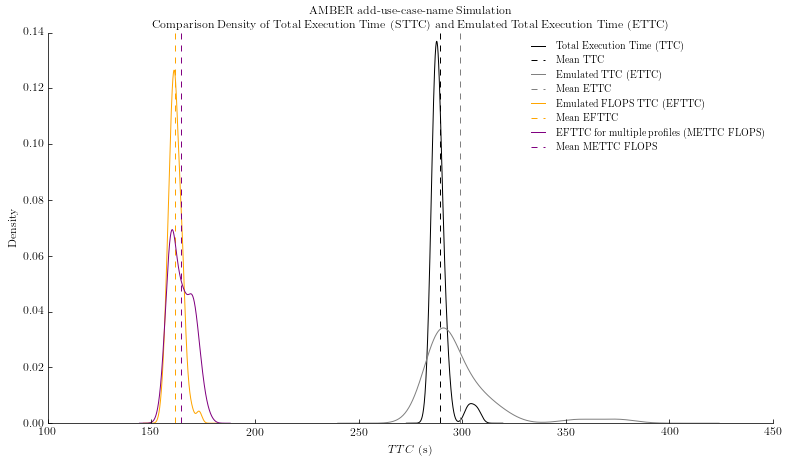

In [13]:
fig, ax = fig_setup()
title='AMBER add-use-case-name Simulation\nComparison Density of Total Execution Time (STTC) and Emulated Total Execution Time (ETTC)'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(emulation_mean['Emulated TTC'].dropna().tolist()))

# TTC
baseline[['TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)
plt.axvline(baseline['TTC'].dropna().mean(), color='black', linestyle='dashed', linewidth=1)

# Emulated FLOPS+I/O TTC
emulation_prof[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='gray', title=title)
plt.axvline(emulation_prof['Emulated TTC'].dropna().mean(), color='gray', linestyle='dashed', linewidth=1)

# Emulated FLOPS TTC
emulation_mean[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='orange', title=title)
plt.axvline(emulation_mean['Emulated TTC'].dropna().mean(), color='orange', linestyle='dashed', linewidth=1)

# Emulated FLOPS TTC for every profile.
emulation[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='purple', title=title)
plt.axvline(emulation['Emulated TTC'].dropna().mean(), color='purple', linestyle='dashed', linewidth=1)

ax.set_xlabel('$TTC$ (s)')
ax.legend(labels=['Total Execution Time (TTC)', 'Mean TTC',
                  'Emulated TTC (ETTC)', 'Mean ETTC',
                  'Emulated FLOPS TTC (EFTTC)', 'Mean EFTTC',
                  'EFTTC for multiple profiles (METTC FLOPS)', 'Mean METTC FLOPS'])
          #loc='upper center')

plt.savefig('figures/synapse_all.pdf', dpi=600, bbox_inches='tight')

#### Emulation Accuracy and Consistency Across Resources

TBD

### RADICAL-Pilot

RADICAL-Pilot (RP) is a pilot system that enables the execution of scientific workloads and worflows on diverse computing infrastructures. We developed RP by defining an explicit event and state model in which events can be defined for each software component and states are events guaranteed to be ordered on a sequence. Each event is timestamped and all the timestamps are collected at the end of the execution. The timestamping has virtually no impact on the performance of RP and on the execution of the workload: each timestamp is performed independently and recorded in memory and recorded asynchrnously on local filesystem without any communication or coordination with other processes. All the timestamps are retrieved at the end of the execution enabling ''post-mortem'' analysis. 

### RADICAL-Analytics


## Design of Experiments

XOVC resources are dynamic and heterogeneous by design: resource availability is not guaranteed by a service level agreement and their capabilities are not assumed to be homogeneous. Resources are not specifically architected to serve XOVC use cases and are not exclusively dedicated to XVOC. They are utilized by a selected group of users and are opportunistically shared with XSEDE users via XOVC only when underutilized. The same applies to resource capabilities: resources have diverse CPU architectures, networking bandwidth and latency, and local or networked storage facilities. It is important to note that this design choice is not mandated by the utilized technologies: The Condor framework does not mandate opportunistic computing, it enables it when it is chosen as the resource provisioning model.

The opportunistic provision of XVOC resources and their assumed heterogeneity introduces uncertainty in distributed execution of workloads. The concurrency of the distributed execution and the duration of each task are unpredictable due to undefined resource availability and heterogeneity. Policies constrain this uncertainty by limiting the type of tasks that should be submitted to XOVC and keeping a total average of 1000 cores available at any point in time. Consistently, XSEDE users are invited to run single-threaded executables that use less than 2GB of memory and run for up to 12 hours. These policies contribute to constrain uncertainty but do not characterize it: the concurrency of distributed executions of tasks consistent with the indicated parameters and the distribution of the duration of these tasks remain indeterminate. 

We designed nine experiments (Table~\ref{table:experiments}) to characterize how the heterogeneity and dynamism of XVOC relate to the time taken to execute a set of tasks within the boundaries set by XOVC policies. Experimental data enables to understand the trade offs between the number of requested resources, the number of obtained resources, and the time taken to execute the tasks of the workload on those resources. For each experiment we fixed the number of flops required by each task to a constant number. This enabled us to study the distribution of time taken to execute task with the same compute requirements across heterogeneous resources as the result of the heterogeneity of the resources used for the execution. We measured the number of flops of our tasks by profiling an AMBER MD simulation as parametrized by our target use case, and we emulated the computation of those flops via Synapse. In this way, the results of our experiments can be directly correlated to the use case. 

We measured the dynamism of XOVC resources by setting 2 independent variables for each experiment:

* number of tasks of the workload; 
* number of pilots we request to execute them;

and measuring 14 dependent variables: 

* Total time to completion of the workload ($TTC$);
* Total time spent by the pilots waiting in the XVOC queue ($TTQ$);
* Total time spent executing tasks ($TTX$);
* Time spent by a pilot waiting in the XVOC queue ($T_q$);
* Time pent by a task executing ($T_x$);
* number of pilots that become active;
* number of pilots that failed;
* hosts on which pilots become active;
* hosts on which pilots failed;
* number of tasks executed;
* number of tasks failed;
* number of tasks rescheduled;
* number of tasks executed per pilot;
* number of tasks executed per host.

We executed between 8 and 2048 tasks requesting between 8 and 2048 pilots. Each pilot corresponds to a single-core job submitted to XOVC. Once scheduled, the job bootstraps a pilot agent that, once active, pulls tasks from the pilot agent of the user's workstation. Tasks require to download the Synapse executable that in turns requires a python interpreter and a C compiler to execute. When successfully compiled, Synapse emulates the AMBER execution until the configured amount of FLOPS has been consumed. Upon termination of all the tasks of the workload, the execution session is closed and the timestamps of all the relevant events recorded for pilots and tasks are downloaded for 'postmortem' analysis. 

Our experimental design assumes: no resource overcommitment and no input/output file staging. We do not request more pilots than tasks we have to execute. While requesting more pilots may ...


| Experiment | <center>#CU</center>                                                      | #Pilots | #Repetitions |
|:----------:|--------------------------------------------------------------------------:|---------|--------------|
| 1          | 8,16,32,64,128,256,512<span style="color:white">..................</span> | 8       | 4/8          |
| 2          |   16,32,64,128,256,512,<span style="color:red">1024</span><span style="color:white">.........</span>           | 16      | 4/8          |
| 3          |      32,64,128,256,512,<span style="color:orange">1024,2048</span>        | 32      | 4/8          |
| 4          |         64,128,256,512,1024,2048                                          | 64      | 4/8          |
| 5          |            128,256,512,1024,2048                                          | 128     | 4/8          |
| 6          |                256,512,1024,2048                                          | 256     | 4/8          |
| 7          |                    512,1024,2048                                          | 512     | 4/8          |
| 8          |                        1024,2048                                          | 1024    | 4/8          |
| 9          |                             2048                                          | 2048    | 4/8          |
[Table 1. Summary of the experiment independent variables. Red numbers of CU indicates that no data has been yet collected for those variables; orange that an experiment is undergoing to collect data. Number of repetitions indicates how many times an experiment has been repeated and how many times will have to be repeated.]

## TODO

* Compare distributions among different numbers of FLOPs. Is the distribution that we assume being a index of heterogeneity sensitive to the number of FLOPs we execute? Ideally, it should not.
* Plot the ideal TTC of the 9 experiment
* Verify that the total number of pilots and the total number of units gives an average number of units executed per pilot consistent with the Tx distribution we have.
* Plot hosts ordered by the number of units they have executed and plot on the y the average and std Tx of those units.
* PUNCH LINE: At any point of time, what charactericts does my federation have to have to get N task of this type executed?
* Chebishev inequality? When to truncate a long tail based on the number of events that can happen down the tail compared to the number of events we have.

## Results and Discussion

\mtnote{Description}

Load wrangled data saved in .csv files.

In [14]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

Drop experiments with at least 8 tasks but less than 8 pilots.

In [15]:
sessions = sessions[sessions.experiment != 'exp1']
pilots = pilots[pilots.experiment != 'exp1']
units = units[units.experiment != 'exp1']
sessions = sessions[sessions.experiment != 'exp2']
pilots = pilots[pilots.experiment != 'exp2']
units = units[units.experiment != 'exp2']
sessions = sessions[sessions.experiment != 'exp3']
pilots = pilots[pilots.experiment != 'exp3']
units = units[units.experiment != 'exp3']
display(sessions.experiment.unique())
display(pilots.experiment.unique())
display(units.experiment.unique())

array(['exp10', 'exp4', 'exp5', 'exp6', 'exp7', 'exp8', 'exp9', 'exp11',
       'exp12', 'exp13', 'exp14', 'exp15'], dtype=object)

array(['exp10', 'exp11', 'exp12', 'exp13', 'exp4', 'exp5', 'exp6', 'exp7',
       'exp8', 'exp9', 'exp14', 'exp15'], dtype=object)

array(['exp10', 'exp4', 'exp5', 'exp6', 'exp7', 'exp8', 'exp9', 'exp11',
       'exp12', 'exp13', 'exp14', 'exp15'], dtype=object)

Check for spurious data due to bugs and drop them

In [16]:
#display(sessions.loc[sessions['TTC']>=43200][['TTC','experiment','nunit_requested','npilot']])
sessions = sessions.drop(['rp.session.radical.mturilli.017128.0000', 'rp.session.radical.mturilli.017139.0003'])
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017139.0003']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017128.0000']
units = units[units.sid != 'rp.session.radical.mturilli.017139.0003']
units = units[units.sid != 'rp.session.radical.mturilli.017128.0000']

Derive number of units requested and number of units rescheduled due to pilot halted/migrated by condor

In [17]:
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

Drop runs with nunit_requested < npilot

In [18]:
runs = sessions[sessions.nunit_requested < sessions.npilot]['sid'].tolist()
sessions = sessions[sessions.nunit_requested >= sessions.npilot]
for run in runs:
    pilots = pilots[pilots.sid != run]
    units = units[units.sid != run]
    
display(sessions[sessions.nunit_requested < sessions.npilot])
#display(pilots.sid.isin(runs))
#display(units.sid.isin(runs))

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,TTC,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,...,experiment,nhost,npilot,npilot_active,nunit,nunit_done,nunit_failed,sid,nunit_requested,nunit_rescheduled


List sessions, pilots, and units > 12 hours (43200 seconds)

In [19]:
display(sessions.loc[sessions['TTC']>=43200][['TTC','experiment','nunit_requested','npilot']])
display(pilots.loc[pilots['P_LRMS_RUNNING']>=43200][['P_LRMS_RUNNING','experiment','sid','pid','nunit']])
display(units.loc[units['U_AGENT_EXECUTING']>=43200][['U_AGENT_EXECUTING','experiment','sid','uid','pid']])

,TTC,experiment,nunit_requested,npilot
rp.session.radical.mturilli.017131.0005,94050.8625,exp9,2048.0,64
rp.session.radical.mturilli.017142.0001,89312.5729,exp13,2048.0,32
rp.session.radical.mturilli.017143.0000,44329.2610,exp13,1024.0,32
rp.session.radical.mturilli.017144.0000,53081.4831,exp13,2048.0,32
rp.session.radical.mturilli.017144.0001,68397.9867,exp13,1024.0,32
rp.session.radical.mturilli.017145.0000,44110.7438,exp13,1024.0,32
rp.session.radical.mturilli.017171.0002,70500.8128,exp14,256.0,8
rp.session.radical.mturilli.017179.0002,105567.6033,exp14,512.0,8
rp.session.radical.mturilli.017183.0000,43925.9589,exp14,512.0,8
rp.session.radical.mturilli.017193.0002,253936.1059,exp14,512.0,8


,P_LRMS_RUNNING,experiment,sid,pid,nunit
16818,6.397365e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0002,124
16823,8.930302e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0007,240
16824,8.928905e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0008,240
16831,6.395686e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0015,140
16832,6.392427e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0016,123
16833,6.397620e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0017,105
16835,6.394775e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0019,134
16844,6.386035e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0028,123
16846,6.394431e+04,exp13,rp.session.radical.mturilli.017142.0001,pilot.0030,106
16868,4.432163e+04,exp13,rp.session.radical.mturilli.017143.0000,pilot.0020,66


,U_AGENT_EXECUTING,experiment,sid,uid,pid


In [20]:
sessions.columns

Index([u'P_LRMS_QUEUING', u'P_LRMS_RUNNING', u'P_LRMS_SUBMITTING',
       u'P_PMGR_QUEUING', u'P_PMGR_SCHEDULING', u'TTC', u'U_AGENT_EXECUTING',
       u'U_AGENT_QUEUING', u'U_AGENT_QUEUING_EXEC', u'U_AGENT_SCHEDULING',
       u'U_UMGR_BINDING', u'U_UMGR_SCHEDULING', u'experiment', u'nhost',
       u'npilot', u'npilot_active', u'nunit', u'nunit_done', u'nunit_failed',
       u'sid', u'nunit_requested', u'nunit_rescheduled'],
      dtype='object')

### Total Time to Completion (TTC)

We measured the time taken by 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks to complete when requesting 8 and 2048 pilots. Figure~\ref{fig:ttc} shows 

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=8.0, right=8.0
  'left=%s, right=%s') % (left, right))


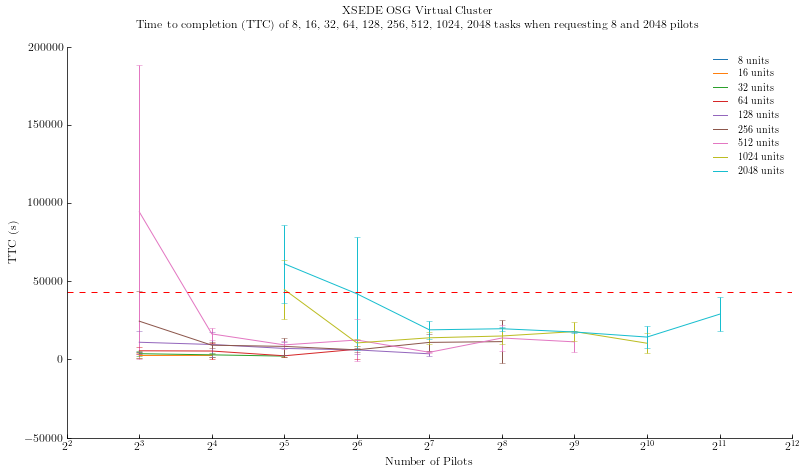

In [21]:
fig, ax = fig_setup()

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Time to completion (TTC) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks when requesting 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

ttc = sessions[
    ['npilot','TTC','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'TTC':{'TTC_mean':'mean','TTC_std':'std'}})
ttc.columns = ttc.columns.droplevel(0)
ttc = ttc.reset_index()

#display(ttc)
colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    color = colors.pop(0)
    ttc.loc[ttc['nunit_requested']==nu].plot(x='npilot', y='TTC_mean', yerr='TTC_std', 
                                             label=str(int(nu))+' units',
                                             color=color,
                                             ax=ax)
#     ttc.loc[ttc['nunit_requested']==nu].plot(x='npilot', y='TTC_std', 
#                                              label='SD',
#                                              color=color, 
#                                              secondary_y=True,
#                                              ax=ax)
    
plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')

ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
ax.set_xlim(2**2, 2**12)
# ax.set_xlim(0, 512)
ax.set_xlabel('Number of Pilots')
ax.set_ylabel('TTC (s)')

plt.savefig('figures/osg_ttc_pilots.pdf', dpi=600, bbox_inches='tight')

### Total Task Execution Time (TTX)

* We note that TTX decreases up to 512 pilots then tends to increase, even when asking for as many as 2048 pilots.\mtnote{Possibly explain this by showing that almost never we get more than 512 pilots, no matter how many we ask for.

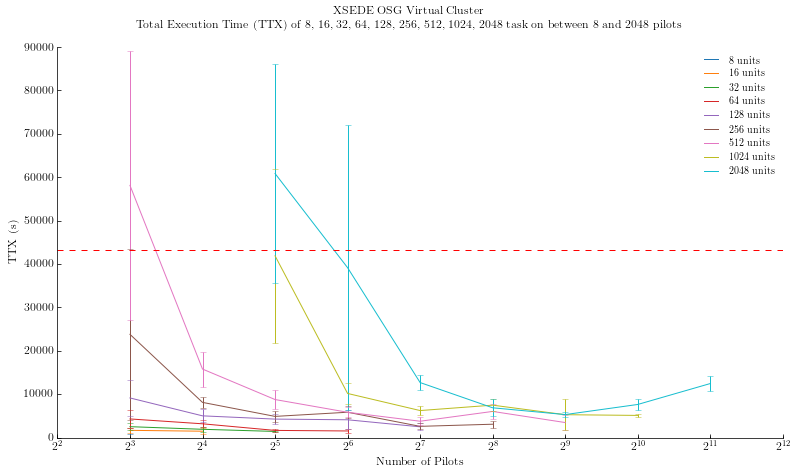

In [22]:
fig, ax = fig_setup()
title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Total Execution Time (TTX) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 task on between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

ttx = sessions[
    ['npilot','U_AGENT_EXECUTING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'U_AGENT_EXECUTING':{'TTX_mean':'mean','TTX_std':'std'}})
ttx.columns = ttx.columns.droplevel(0)
ttx = ttx.reset_index()

#display(ttc)
colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttx.loc[ttc['nunit_requested']==nu].plot(x='npilot', y='TTX_mean', yerr='TTX_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')

ax.set_xscale('log', basex=2)
#ax.set_yscale('log', basey=2)
ax.set_xlim((2**2, 2**12))
ax.set_xlabel('Number of Pilots')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_pilots.pdf', dpi=600, bbox_inches='tight')

### Total Pilot Queuing Time (TTQ)

NOTE: There may be something wrong with a couple of data point responsible for the off-the-chart error bars. I found a similar problem with TTC. Will need to investigate further.

In [23]:
sessions[(sessions['npilot']==64) & (sessions['nunit_requested']==2048)][['experiment','npilot','TTC','P_LRMS_QUEUING','nunit_requested']]

,experiment,npilot,TTC,P_LRMS_QUEUING,nunit_requested
rp.session.radical.mturilli.017131.0001,exp9,64,39116.7173,402.1958,2048.0
rp.session.radical.mturilli.017131.0005,exp9,64,94050.8625,63879.8725,2048.0
rp.session.radical.mturilli.017133.0001,exp9,64,17867.1074,417.4258,2048.0
rp.session.radical.mturilli.017133.0003,exp9,64,17031.7817,614.9169,2048.0


See https://github.com/radical-cybertools/radical.analytics/issues/25 for an analysis of the outlier rp.session.radical.mturilli.017131.0005. It seems we did hit $T_q$ indeed. That anlysis confirmed the relevance of the following two questions:
1. Average number of units executed per pilots;
2. Number of available pilots at 'every' point in time of the execution.

In [24]:
sessions[sessions['npilot']==4]#[['experiment','npilot']]
sessions[sessions.nunit_requested==2048]
#ttq
# sessions[['npilot','P_LRMS_QUEUING','nunit_requested']]
# pilots[pilots.sid=='rp.session.radical.mturilli.017131.0005'].dropna()
sessions[sessions.sid=='rp.session.radical.mturilli.017131.0005']

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,TTC,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,...,experiment,nhost,npilot,npilot_active,nunit,nunit_done,nunit_failed,sid,nunit_requested,nunit_rescheduled
rp.session.radical.mturilli.017131.0005,63879.8725,38518.5086,41.6959,0.0101,0.2141,94050.8625,86431.017,15.397299,64.482495,85912.6692,...,exp9,9,64,60,2104,2101,116,rp.session.radical.mturilli.017131.0005,2048.0,56.0


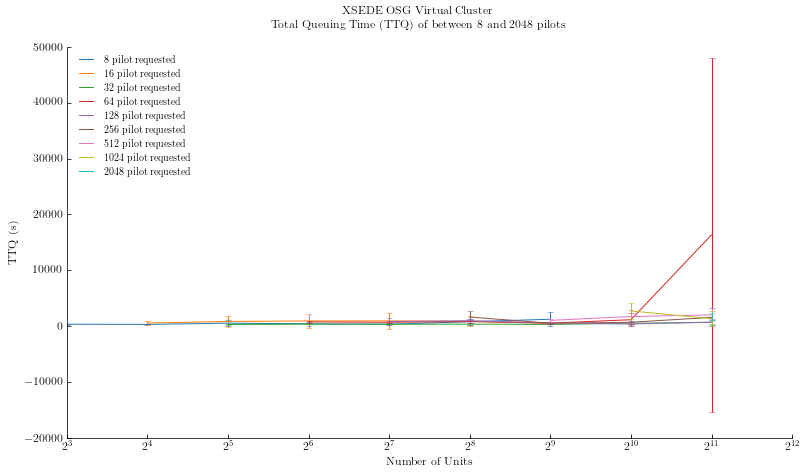

In [25]:
fig, ax = fig_setup()
title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Total Queuing Time (TTQ) of between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

ttq = sessions[
    ['npilot','P_LRMS_QUEUING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'P_LRMS_QUEUING':{'TTQ_mean':'mean','TTQ_std':'std'}})
ttq.columns = ttq.columns.droplevel(0)
ttq = ttq.reset_index()

#display(ttc)
colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

nps = ttq['npilot'].unique()
nps.sort()

for np in nps:
    ttq.loc[ttq['npilot']==np].plot(x='nunit_requested', y='TTQ_mean', yerr='TTQ_std', 
                                             label=str(int(np))+' pilot requested',
                                             color=colors.pop(0),
                                             ax=ax)

ax.set_xscale('log', basex=2)
#ax.set_yscale('log', basey=2)
ax.set_xlim((0, 2**12))
ax.set_xlabel('Number of Units')
ax.set_ylabel('TTQ (s)')

plt.savefig('figures/osg_ttq_pilots.pdf', dpi=600, bbox_inches='tight')

### Tasks Execution Time ($T_x$)

* What is the distribution of $T_x$?
* What is the distribution of $T_x$ per host?
* What is the distribution of $T_x$ per experiment?

NormaltestResult(statistic=79320.723712189414, pvalue=0.0)

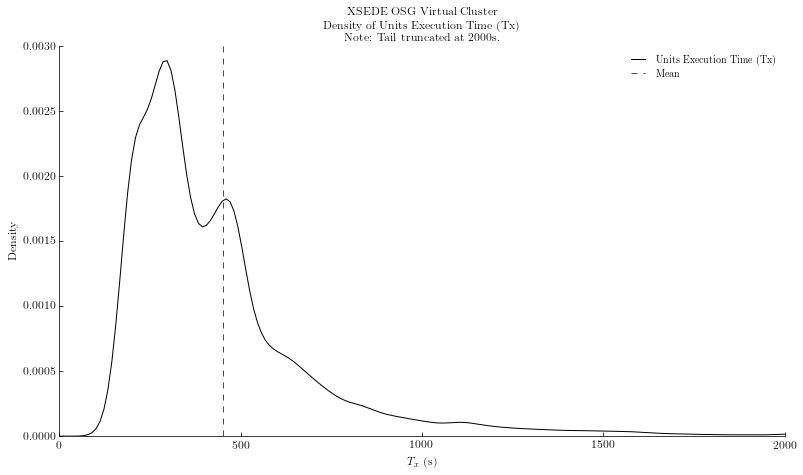

In [26]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\nNote: Tail truncated at 2000s.'

display(sps.normaltest(units['U_AGENT_EXECUTING'].dropna().tolist()))
units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Units Execution Time (Tx)', 'Mean'])

plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

In [27]:
# fig, ax = fig_setup()
# # title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\nNote: Tail truncated at 2000s.'

# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.serif']  = ['Helvetica']

# mpl.rcParams['legend.frameon'] = False
# mpl.rcParams['patch.linewidth'] = 2

# SIZE = 30
# plt.rc('font', size=SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
# plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=SIZE)  # legend fontsize
# plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# mpl.rcParams['lines.linewidth'] = 4
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

# display(sps.normaltest(units['U_AGENT_EXECUTING'].dropna().tolist()))
# units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black')#, title=title)

# #plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
# plt.axvline(units['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
# #plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

# #ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
# ax.set_xlim(0, 2000)
# ax.set_xlabel('$T_x$ (s)')
# ax.legend(labels=['Units Execution Time (Tx)', 'Mean'])

# plt.savefig('figures/osg_tx_all_frequency_direct.pdf', dpi=600, bbox_inches='tight')

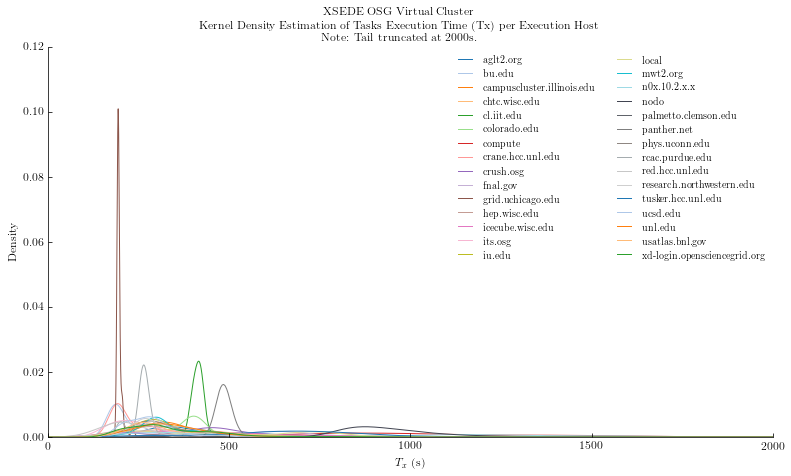

In [28]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nKernel Density Estimation of Tasks Execution Time (Tx) per Execution Host\nNote: Tail truncated at 2000s.'
fig.suptitle(title)

curves = {}
hosts = units['hid'].dropna().unique()

minni = units.loc[units['U_AGENT_EXECUTING'].notnull()]

for host in hosts:
    curves[host] = minni.loc[units['hid'] == host]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

curves = dict((k.lower(), v) for k,v in curves.iteritems())    
utxh = pd.DataFrame(curves) 
utxh.plot.density(ax=ax, sort_columns=True, color=tableau20)#, linewidth=2)#, figsize=(15, 13), title=title) # subplots=True, layout=(4,4), sharey=True, sharex=True,

ax.legend(ncol=2)
ax.set_xlim((0, 2000))
ax.set_xlim((0))
ax.set_xlabel('$T_x$ (s)')

plt.savefig('figures/osg_tx_hosts_frequency.pdf', dpi=600, bbox_inches='tight')

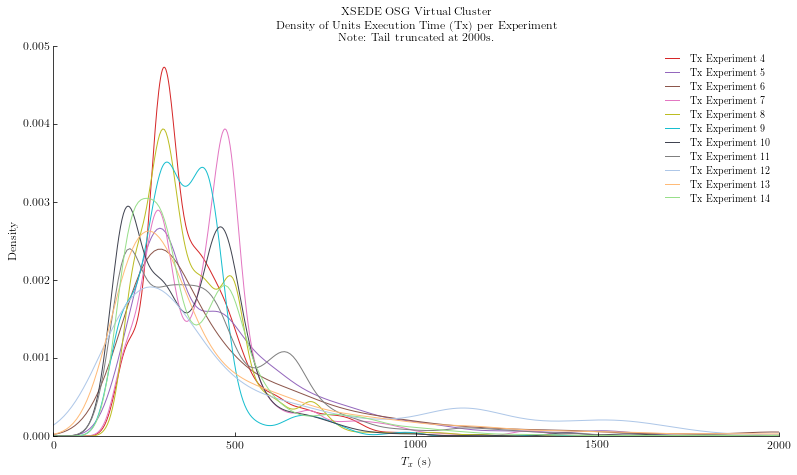

In [29]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx) per Experiment\nNote: Tail truncated at 2000s.'

# tx_exp1  = units[units['experiment'].str.contains('exp1' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
# tx_exp2  = units[units['experiment'].str.contains('exp2' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
# tx_exp3  = units[units['experiment'].str.contains('exp3' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp4  = units[units['experiment'].str.contains('exp4' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp5  = units[units['experiment'].str.contains('exp5' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp6  = units[units['experiment'].str.contains('exp6' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp7  = units[units['experiment'].str.contains('exp7' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp8  = units[units['experiment'].str.contains('exp8' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp9  = units[units['experiment'].str.contains('exp9' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp10 = units[units['experiment'].str.contains('exp10')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp11 = units[units['experiment'].str.contains('exp11')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp12 = units[units['experiment'].str.contains('exp12')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp13 = units[units['experiment'].str.contains('exp13')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp14 = units[units['experiment'].str.contains('exp14')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({#'exp1': tx_exp1  , 'exp2': tx_exp2  , 'exp3': tx_exp3, 
                     'exp4' : tx_exp4 , 'exp5' : tx_exp5 , 'exp6' : tx_exp6 , 
                     'exp7' : tx_exp7 , 'exp8' : tx_exp8 , 'exp9' : tx_exp9 ,
                     'exp10': tx_exp10, 'exp11': tx_exp11, 'exp12': tx_exp12,
                     'exp13': tx_exp13, 'exp14': tx_exp14})

utxs.plot.density(ax=ax, color=[#tableau20[0 ],tableau20[2 ],tableau20[4 ],
                                tableau20[6 ],tableau20[8 ],tableau20[10],
                                tableau20[12],tableau20[14],tableau20[16],
                                tableau20[18],tableau20[20],
                                tableau20[1] ,tableau20[3] ,tableau20[5]], title=title)

ax.set_xlim((0, 2000))
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=[#'Tx Experiment 1' , 'Tx Experiment 2' , 'Tx Experiment 3', 
                  'Tx Experiment 4' , 'Tx Experiment 5' , 'Tx Experiment 6',
                  'Tx Experiment 7' , 'Tx Experiment 8' , 'Tx Experiment 9',
                  'Tx Experiment 10', 'Tx Experiment 11', 'Tx Experiment 12',
                  'Tx Experiment 13', 'Tx Experiment 14'])

plt.savefig('figures/osg_tx_experiments_frequency.pdf', dpi=600, bbox_inches='tight')

### Pilot Queue Waiting Time ($T_q$)

* What is the distribution of $T_x$?
* What is the distribution of $T_x$ per host?
* What is the distribution of $T_x$ per experiment?

NormaltestResult(statistic=38639.257870528236, pvalue=0.0)

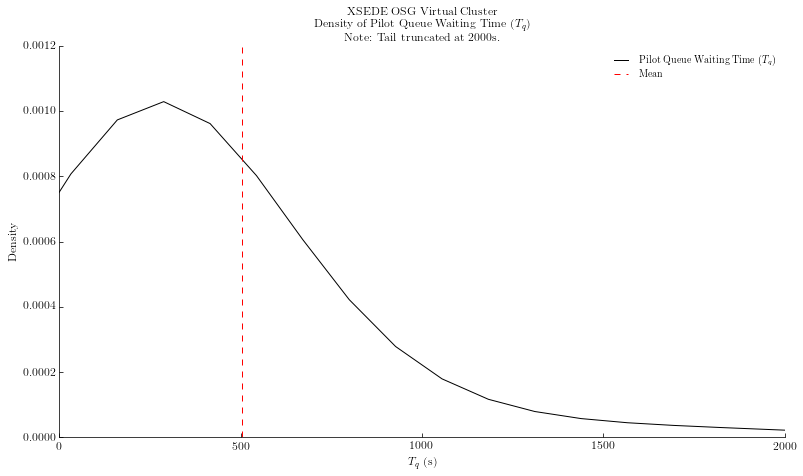

In [30]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Pilot Queue Waiting Time ($T_q$)\nNote: Tail truncated at 2000s.'

display(sps.normaltest(pilots['P_LRMS_QUEUING'].dropna().tolist()))
# display(pilots[['P_PMGR_QUEUING']].dropna())
pilots.loc[pilots['nunit']>1][['P_LRMS_QUEUING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(pilots['P_LRMS_QUEUING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_q$ (s)')
ax.legend(labels=['Pilot Queue Waiting Time ($T_q$)', 'Mean'])

plt.savefig('figures/osg_tq_all_frequency.pdf', dpi=600, bbox_inches='tight')

Single pilot queue time is ~8.3 minutes on average with a fairly long tail. The impact of the tail on execution time needs to be investigated by comparing it to the average TTQ, i.e. the total time spent queuing as a portion of TTC. This comparison tells us whether the pilots of the long tail waiting a long time while **other** pilots were already active. This is also a good measure of the importance of late binding with back filling on pilots on OSG and, ultimately, a justification of the use of single-core pilots. For this reason, the very long tail could be good news for the need to position/justify the paper.

### Pilot Running Time ($T_r$)

* What is the distribution of $T_r$?
* What is the distribution of $T_r$ per host?
* What is the distribution of $T_r$ per experiment?

In [31]:
units.dropna().describe()
pilots.dropna().describe()

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,nunit
count,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000,14943.000000
mean,445.813890,6783.544173,174.107119,0.082084,1.356083,7.019407
std,474.218047,6463.626639,150.019996,0.079410,5.253391,15.132950
min,0.000200,-0.090100,26.111100,0.001400,0.095200,0.000000
25%,197.854050,3875.397700,64.266900,0.024700,0.328800,2.000000
50%,299.505200,5263.061600,119.787300,0.060300,0.639500,3.000000
75%,499.889100,7392.415300,291.028600,0.103100,0.940000,6.000000
max,3972.745800,253637.863400,583.088000,0.296800,56.327400,729.000000


NormaltestResult(statistic=42453.256424385407, pvalue=0.0)

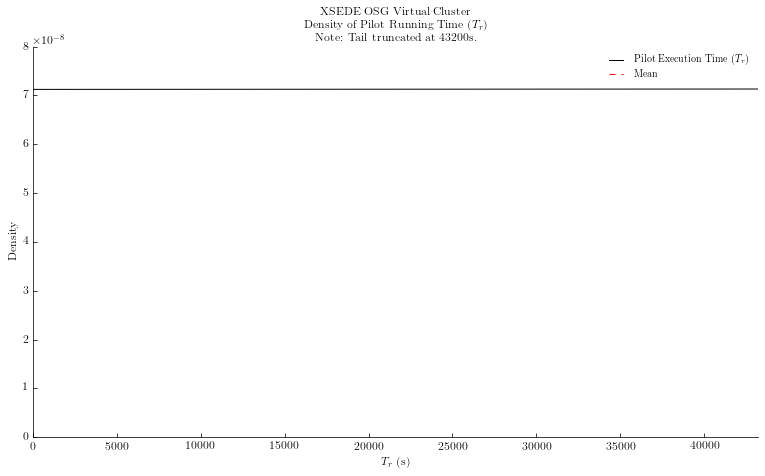

In [32]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Pilot Running Time ($T_r$)\nNote: Tail truncated at 43200s.'

display(sps.normaltest(pilots['P_LRMS_RUNNING'].dropna().tolist()))
# display(pilots[['P_PMGR_QUEUING']].dropna())
pilots.loc[pilots['nunit']>1][['P_LRMS_RUNNING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(pilots['P_LRMS_RUNNING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 43200)
ax.set_xlabel('$T_r$ (s)')
ax.legend(labels=['Pilot Execution Time ($T_r$)', 'Mean'])

plt.savefig('figures/osg_tr_all_frequency.pdf', dpi=600, bbox_inches='tight')

Pilots are active for an average of mostly 2 hours. Next step is to look at average duration of pilots during runtime: do the pilots terminate becuase there are no more tasks to run or is there a dominant average time in which the pilots are active and then are terminated/preempted?

### Resource Dynamism
* How many resources are used on average for each experiment' BoT?
* Does the number of resources vary among experiments' BoT?
* Does the number of resources vary during the execution of each experiment's BoT?

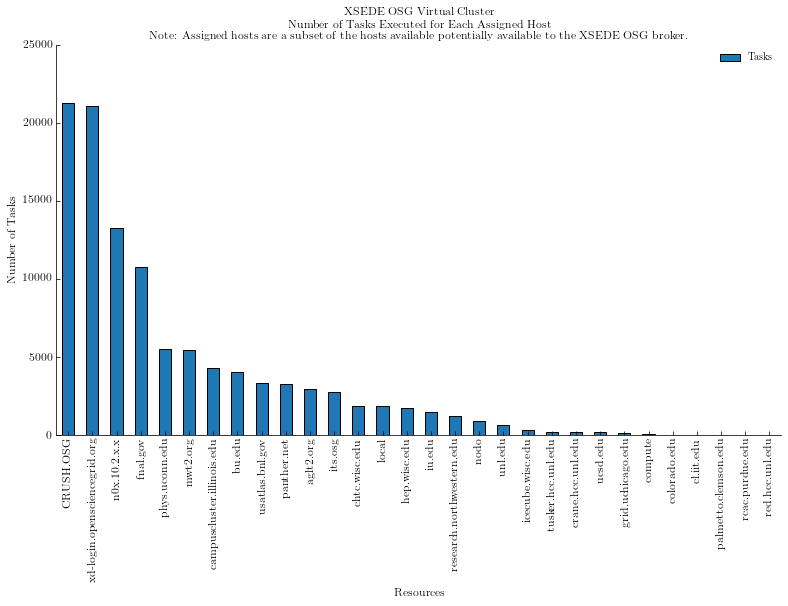

In [33]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\nNote: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')
ax.legend(labels=['Tasks'])

plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

### Pilot Dynamism
* How many active pilots are used on average for each experiment's BoT?
* Does the number of active pilots vary among experiments' BoT?
* Does the number of active pilots vary during the execution of each experiment's BoT?

#### TODO
* We aggegated across number of units. We should investigate the differences among number of units. Is the slope 1 up to 512 independent of the number of units?

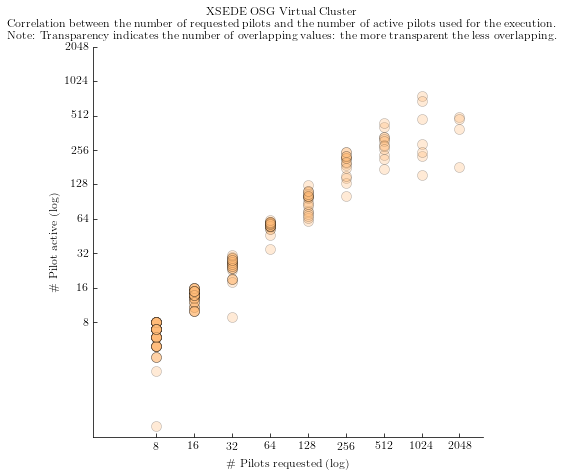

In [34]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested pilots and the number of active pilots used for the execution.\n'+\
'Note: Transparency indicates the number of overlapping values: the more transparent the less overlapping.'
fig.suptitle(title)

qui = sessions.rename(columns={'npilot_active':'NpActive'}).copy()
ax.scatter(qui['npilot'], qui['NpActive'], s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((10**0.4, 10**3.5))#-50, 550))
ax.set_ylim((10**-0.1, 10**3.2))

plt.minorticks_off()
plt.xticks([8,16,32,64,128,256,512,1024,2048], [8,16,32,64,128,256,512,1024,2048])
plt.yticks([8,16,32,64,128,256,512,1024,2048], [8,16,32,64,128,256,512,1024,2048])
plt.xlabel('\# Pilots requested (log)')
plt.ylabel('\# Pilot active (log)')

plt.savefig('figures/osg_scatter_npilots-requested_npilots-active.pdf', dpi=600, bbox_inches='tight')

### Correlation Between Resource and Pilot Dynamism
* Does the number of resources used for each experiment's BoT execution correlate to the number of pilots requested?
* Does the number of resources used for each experiment's BoT execution correlate to the number of active pilots?
* Does the variation of the number of pilots correlate to variation of the number of resources during runtime?
* Noise reduction and bias elimination? What is the gradient of the correlation? I need 

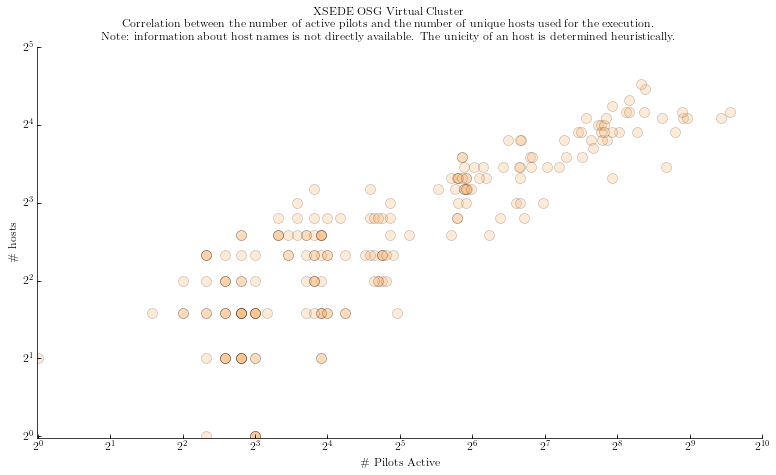

In [35]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of active pilots and the number of unique hosts used for the execution.\n'+\
'Note: information about host names is not directly available. The unicity of an host is determined heuristically.'
fig.suptitle(title)

paperino = sessions.copy()
ax.scatter(paperino['npilot_active'], paperino['nhost'], s=100, alpha=0.3, facecolor=tableau20[3], lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('\# Pilots Active')
plt.ylabel('\# hosts')
ax.set_xlim((-10))
ax.set_ylim((0))

plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

The number of active pilots of an execution seems to correlate positevely and strongly to the number of hosts used for the execution. The relation between the two variables seems to be monotonic with a relatively low number of outliner. We calculate the sample Pearson and Spearman correlation coefficients for testing non-correlation~\mtnote{For non-linear monotonic relations Pearson test is adequate to indicate the existence and direction of statistical dependence, less adequate to indicate its strenght. Pearson test is sensitive to outliners while Spearman is not. Also, Spearman seems more adequate with high level of skewness, that we have.}. 

In [36]:
import numpy as np

# Get Pearson r and p-value
r,pv = sps.pearsonr(paperino['npilot_active'], paperino['nhost'])
rho,rpv = sps.spearmanr(paperino['npilot_active'], paperino['nhost'])
tau,tpv = sps.kendalltau(paperino['npilot_active'], paperino['nhost'])

# Use the Fisher transformation to get z
z = np.arctanh(r)

# Calculate sigma (std error) of sampling distribution size N (i.e., N of paperino) 
# of z (assumed to be approximately normally distributed). 
# The formulat is $\frac{1}{\sqrt[N-3]}$
sigma = (1/((len(paperino.index)-3)**0.5))

# Get normal 95% interval probability density function for normal
# continuous random variable apply two-sided conditional formula
cint = z + np.array([-1, 1]) * sigma * sps.norm.ppf((1+0.95)/2)

# take hyperbolic tangent to get interval values for 95%
rcint = np.tanh(cint)

print '(Pearson) r = %s\n(Spearman) rho = %s\n(Kendall) tau = %s\nz = %s\nsigma = %s\n95%% confidence interval = %s' % (r, rho, tau, z, sigma, rcint)

(Pearson) r = 0.810916975934
(Spearman) rho = 0.868080941762
(Kendall) tau = 0.711232739093
z = 1.12970120657
sigma = 0.0710669054519
95% confidence interval = [ 0.75753822  0.85352362]


We test whether the two distributions of number of active pilots and number of hosts are approximately normal by performing a chi squared test. When the two distribution are not normal, the correlation provides an incomplete description of the association.

Note: the following distributions depend on the number of runs performed in the experiments. The more runs with a greater number of requested pilots, the less skewned the distributions. This is probably an indication we should look into balancing the number of runs across the experiments. At the moment, this is unbalanced towards lower values of requested pilots (and therefore active pilots and lower number of hosts, assuming correlation between requested pilots and active pilots; and active pilots and number of hosts).

NormaltestResult(statistic=22.584118687249322, pvalue=1.2471564517592365e-05)

(0, 35.0)

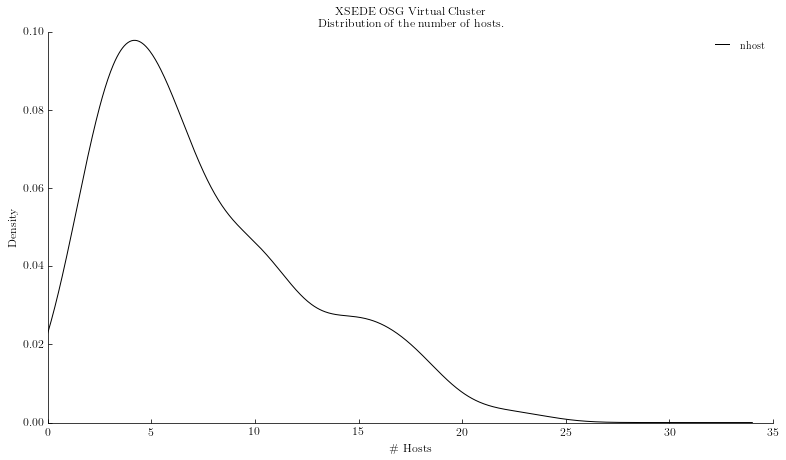

In [37]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nDistribution of the number of hosts.'

display(sps.normaltest(paperino['nhost'].dropna().tolist()))
paperino[['nhost']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

plt.xlabel('\# Hosts')
ax.set_xlim(0)
    
# plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

NormaltestResult(statistic=135.85694079479501, pvalue=3.1552962571473634e-30)

(0, 1200.0)

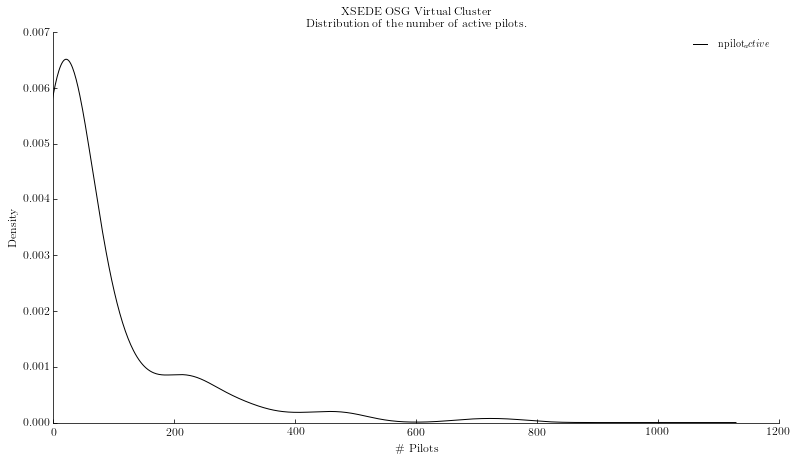

In [38]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nDistribution of the number of active pilots.'

display(sps.mstats.normaltest(paperino['npilot_active'].dropna().tolist()))
paperino[['npilot_active']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

plt.xlabel('\# Pilots')
ax.set_xlim(0)

# plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

Both the sample Pearson and Spearman tests suggests correlation: the more active pilots the more hosts are used for the execution. This has relevant implications:

* the number of pilots that can become active on every resource is limited. If we bypass or 'direct' the resource selection operated by the XOVC, we will have to select a pool with a number of hosts proportional to the number of pilots that we request.
* The number of pilots that can become concurrently active is likely to be bounded. As the number of hosts is upper bounded, once all the host available have been used to execute some pilot, no more pilot will become active. This is confirmed by the plot under the subsection 'Pilot dynamism': the number of concurrent active pilots seems to cap at around 512. 

### Correlation Between Resource Dynamism and TTC
* Does the number of resources used to execute experiments' BoT correlate to variations in the BoT TTC?
* Does the variation of the number of resources during the execution of the experiments' BoT correlate to the BoT TTC?

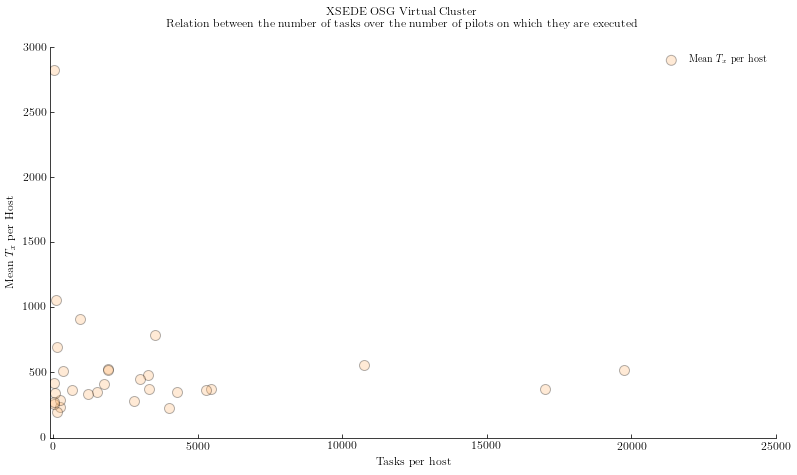

In [39]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Relation between '+\
'the number of tasks over the number of pilots on which they are executed'
fig.suptitle(title)

pluto = units
x = pluto.loc[pluto['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count()
y1 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').min().add_prefix('min_')
y2 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').mean().add_prefix('mean_')
y3 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').max().add_prefix('max_')
scatter = pd.concat([x, y1, y2, y3], axis=1).sort_values(by='uid', ascending=False)

# display(scatter)

# scatter.plot.scatter('uid', 'min_U_AGENT_EXECUTING', s=100, ax=ax, color=tableau20[1], lw=0.5)

# ax.scatter(scatter['uid'], scatter['min_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[1], label='Min $T_x$ per host')
ax.scatter(scatter['uid'], scatter['mean_U_AGENT_EXECUTING'], s=100, alpha=0.3, facecolor=tableau20[3], label='Mean $T_x$ per host')
# ax.scatter(scatter['uid'], scatter['max_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[5], label='Max $T_x$ per host')

plt.xlabel('# Tasks per host')
plt.ylabel('Mean $T_x$ per Host')
ax.set_xlim((-100))
# ax.set_ylim((0, 6000))
ax.legend(scatterpoints=1)

plt.savefig('figures/osg_scatter_task-per-host_tx-per-host.pdf', dpi=600, bbox_inches='tight')

### Correlation Between Pilot Dynamism and TTC
* Does the number of active pilots used to execute experiments' BoT correlate to variations in the BoT TTC?
* Does the variation of the number of active pilots during the execution of the experiments' BoT correlate to the BoT TTC?
* Does the ration between active pilots and single hosts correlate to the BoT TTC?

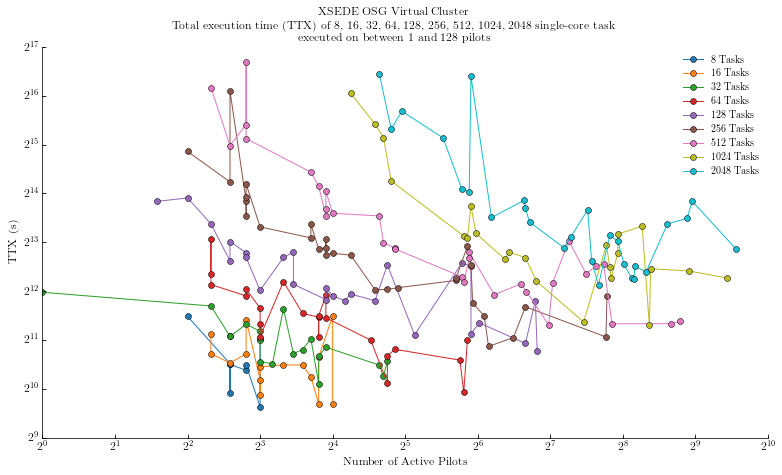

In [40]:
fig, ax = fig_setup()
fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 single-core task\nexecuted on between 1 and 128 pilots')

s = sessions.rename(columns={'npilot_active':'npilotactive'})

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1],
        tableau20[3], tableau20[5], tableau20[7], tableau20[9],
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    unts = s[s['nunit_requested']==u][['U_AGENT_EXECUTING', 'npilotactive']].dropna().sort_values('npilotactive').copy()
    ax.plot(unts.npilotactive, unts.U_AGENT_EXECUTING, marker='o', label='%s Tasks' % u, color=colors.pop(0))

#ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.legend(numpoints=1)
ax.set_xlabel('Number of Active Pilots')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_active-pilots.pdf', dpi=600, bbox_inches='tight')

NOTE: The use of the estimated regression probably makes no sense in this context. I use it as a placeholder to remember myself to study about it.

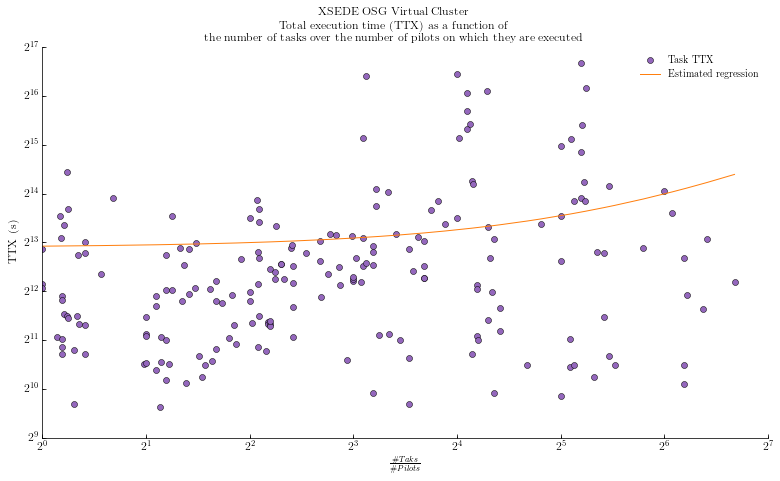

In [41]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

x = s['NuOnNpActive'].dropna().sort_values()
y = s['U_AGENT_EXECUTING'].dropna()
fit = np.polyfit(x, y, 1)
fit_fn = np.poly1d(fit)

ax.plot(x, y, marker='o', color=tableau20[8], linestyle='', label='Task TTX')
ax.plot(x, fit_fn(x), color=tableau20[2], label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots.pdf', dpi=600, bbox_inches='tight')

### Resource Heterogeneity
* Is there a direct/indirect measurement of CPU heterogeneity across resources used to execute experiments' BoT?
* Is there a direct/indirect measurement of geographical heterogeneity across resources used to execute experiments' BoT?
* Is there a direct/indirect measurement of software stack heterogeneity across resources used to execute experiments' BoT?

### Correlation Between Resource Heterogeneity and TTC
* Does the degree of CPU heterogeneity across resources used to execute experiments' BoT correlate to the BoT TTC?
* Does the degree of geographical heterogeneity across resources used to execute experiments' BoT correlate to the BoT TTC?
* Does the degree of software stack heterogeneity across resources used to execute experiments' BoT correlate to the BoT TTC?

### Failure and Rescheduling

* Is there a set of hosts on which units are often scheduled but often fail to execute?

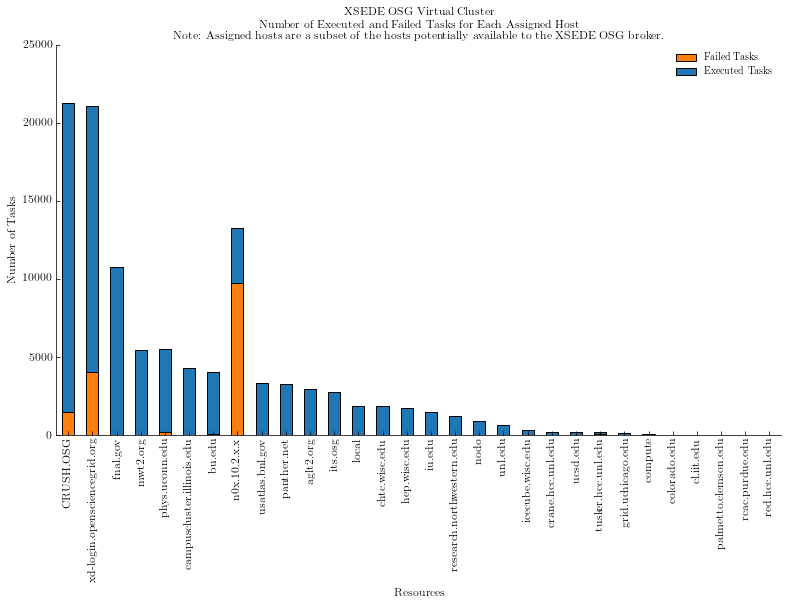

In [42]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of Executed and Failed Tasks for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts potentially available to the XSEDE OSG broker.'

pippo = units

pd.concat(
    [pippo.loc[pippo['U_AGENT_EXECUTING'].isnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Failed Tasks'}),
     pippo.loc[pippo['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Executed Tasks'})], 
    axis=1).sort_values(
        by=['Executed Tasks','Failed Tasks'], 
        ascending=False).plot.bar(
            ax=ax, 
            stacked=True, 
            color=[tableau20[2],tableau20[0]], 
            title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')

plt.savefig('figures/osg_nunits_executed_failed_per_host.pdf', dpi=600, bbox_inches='tight')

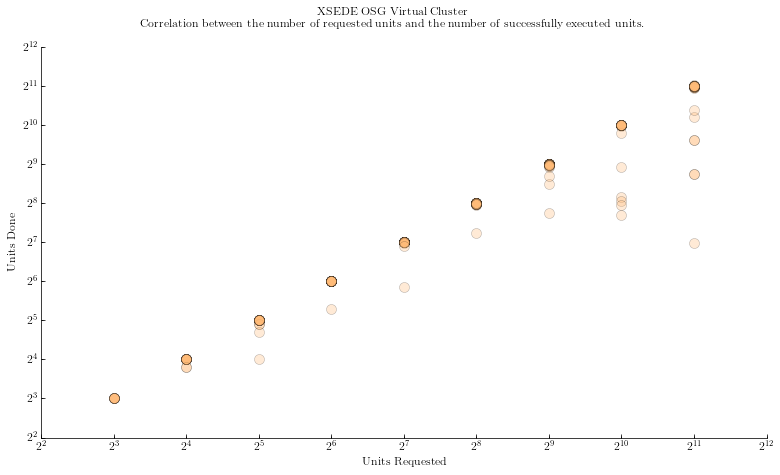

In [43]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested units and the number of successfully executed units.'
fig.suptitle(title)

qua = sessions.copy()
ax.scatter(qua['nunit_requested'], 
           qua['nunit_done'], 
           s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('Units Requested')
plt.ylabel('Units Done')
# ax.set_xlim((-10))
# ax.set_ylim((0))

#plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

In [44]:
import numpy as np

# Get Pearson r and p-value
r,pv = sps.pearsonr(qui['nunit_requested'], qui['nunit_done'])
rho,rpv = sps.spearmanr(qui['nunit_requested'], qui['nunit_done'])
tau,tpv = sps.kendalltau(qui['nunit_requested'], qui['nunit_done'])

# Use the Fisher transformation to get z
z = np.arctanh(r)

# Calculate sigma (std error) of sampling distribution size N (i.e., N of paperino) 
# of z (assumed to be approximately normally distributed). 
# The formulat is $\frac{1}{\sqrt[N-3]}$
sigma = (1/((len(paperino.index)-3)**0.5))

# Get normal 95% interval probability density function for normal
# continuous random variable apply two-sided conditional formula
cint = z + np.array([-1, 1]) * sigma * sps.norm.ppf((1+0.95)/2)

# take hyperbolic tangent to get interval values for 95%
rcint = np.tanh(cint)

print '(Pearson) r = %s\n(Spearman) rho = %s\n(Kendall) tau = %s\nz = %s\nsigma = %s\n95%% confidence interval = %s' % (r, rho, tau, z, sigma, rcint)

(Pearson) r = 0.911523137398
(Spearman) rho = 0.963382086968
(Kendall) tau = 0.909718206994
z = 1.53645728954
sigma = 0.0710669054519
95% confidence interval = [ 0.88473812  0.9323073 ]


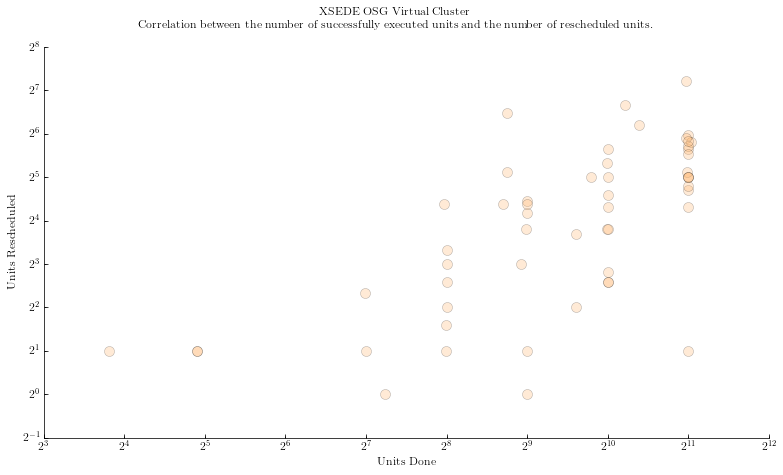

In [45]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of successfully executed units and the number of rescheduled units.'
fig.suptitle(title)

qui = sessions.copy()
ax.scatter(qui[qui.nunit_rescheduled > 0]['nunit_done'], 
           qui[qui.nunit_rescheduled > 0]['nunit_rescheduled'], 
           s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('Units Done')
plt.ylabel('Units Rescheduled')
# ax.set_xlim((-10))
# ax.set_ylim((0))

#plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

In [46]:
import numpy as np

# Get Pearson r and p-value
r,pv = sps.pearsonr(qui['nunit_done'], qui['nunit_rescheduled'])
rho,rpv = sps.spearmanr(qui['nunit_done'], qui['nunit_rescheduled'])
tau,tpv = sps.kendalltau(qui['nunit_done'], qui['nunit_rescheduled'])

# Use the Fisher transformation to get z
z = np.arctanh(r)

# Calculate sigma (std error) of sampling distribution size N (i.e., N of paperino) 
# of z (assumed to be approximately normally distributed). 
# The formulat is $\frac{1}{\sqrt[N-3]}$
sigma = (1/((len(paperino.index)-3)**0.5))

# Get normal 95% interval probability density function for normal
# continuous random variable apply two-sided conditional formula
cint = z + np.array([-1, 1]) * sigma * sps.norm.ppf((1+0.95)/2)

# take hyperbolic tangent to get interval values for 95%
rcint = np.tanh(cint)

print '(Pearson) r = %s\n(Spearman) rho = %s\n(Kendall) tau = %s\nz = %s\nsigma = %s\n95%% confidence interval = %s' % (r, rho, tau, z, sigma, rcint)

(Pearson) r = 0.610525129728
(Spearman) rho = 0.553591477264
(Kendall) tau = 0.446860989612
z = 0.709758113508
sigma = 0.0710669054519
95% confidence interval = [ 0.51570403  0.69057111]


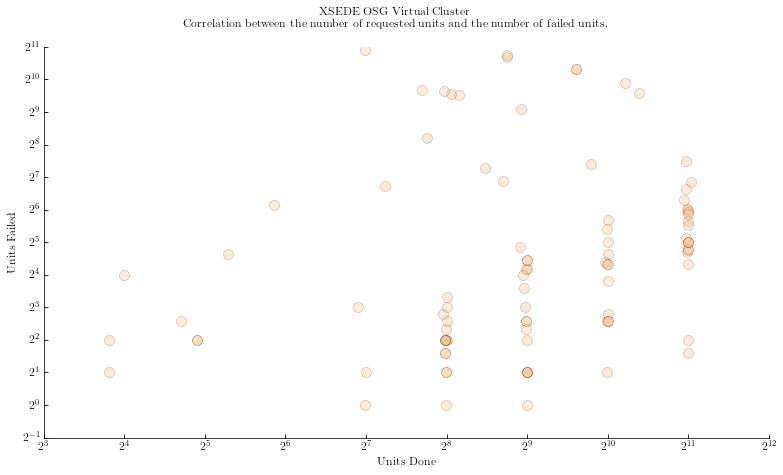

In [47]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested units and the number of failed units.'
fig.suptitle(title)

quo = sessions.copy()
ax.scatter(quo[quo.nunit_failed > 0]['nunit_done'], 
           quo[quo.nunit_failed > 0]['nunit_failed'], 
           s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('Units Done')
plt.ylabel('Units Failed')
# ax.set_xlim((-10))
# ax.set_ylim((0))

#plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

In [48]:
import numpy as np

# Get Pearson r and p-value
r,pv = sps.pearsonr(quo['nunit_done'], quo['nunit_failed'])
rho,rpv = sps.spearmanr(quo['nunit_done'], quo['nunit_failed'])
tau,tpv = sps.kendalltau(quo['nunit_done'], quo['nunit_failed'])

# Use the Fisher transformation to get z
z = np.arctanh(r)

# Calculate sigma (std error) of sampling distribution size N (i.e., N of paperino) 
# of z (assumed to be approximately normally distributed). 
# The formulat is $\frac{1}{\sqrt[N-3]}$
sigma = (1/((len(paperino.index)-3)**0.5))

# Get normal 95% interval probability density function for normal
# continuous random variable apply two-sided conditional formula
cint = z + np.array([-1, 1]) * sigma * sps.norm.ppf((1+0.95)/2)

# take hyperbolic tangent to get interval values for 95%
rcint = np.tanh(cint)

print '(Pearson) r = %s\n(Spearman) rho = %s\n(Kendall) tau = %s\nz = %s\nsigma = %s\n95%% confidence interval = %s' % (r, rho, tau, z, sigma, rcint)

(Pearson) r = 0.0707584445151
(Spearman) rho = 0.58159640073
(Kendall) tau = 0.440135660997
z = 0.0708768906615
sigma = 0.0710669054519
95% confidence interval = [-0.06830516  0.20712487]


In [49]:
#sessions

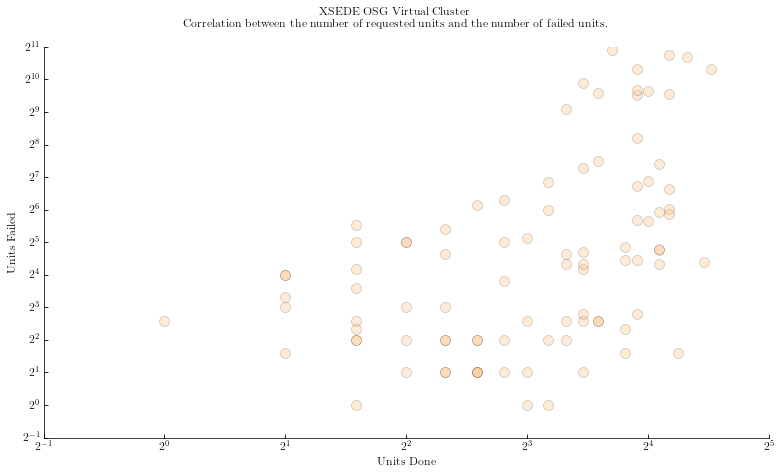

In [50]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested units and the number of failed units.'
fig.suptitle(title)

quo = sessions.copy()
ax.scatter(quo[quo.nunit_failed > 0]['nhost'], 
           quo[quo.nunit_failed > 0]['nunit_failed'], 
           s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('Units Done')
plt.ylabel('Units Failed')
# ax.set_xlim((-10))
# ax.set_ylim((0))

#plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

In [51]:
import numpy as np

# Get Pearson r and p-value
r,pv = sps.pearsonr(quo['nhost'], quo['nunit_failed'])
rho,rpv = sps.spearmanr(quo['nhost'], quo['nunit_failed'])
tau,tpv = sps.kendalltau(quo['nhost'], quo['nunit_failed'])

# Use the Fisher transformation to get z
z = np.arctanh(r)

# Calculate sigma (std error) of sampling distribution size N (i.e., N of paperino) 
# of z (assumed to be approximately normally distributed). 
# The formulat is $\frac{1}{\sqrt[N-3]}$
sigma = (1/((len(paperino.index)-3)**0.5))

# Get normal 95% interval probability density function for normal
# continuous random variable apply two-sided conditional formula
cint = z + np.array([-1, 1]) * sigma * sps.norm.ppf((1+0.95)/2)

# take hyperbolic tangent to get interval values for 95%
rcint = np.tanh(cint)

print '(Pearson) r = %s\n(Spearman) rho = %s\n(Kendall) tau = %s\nz = %s\nsigma = %s\n95%% confidence interval = %s' % (r, rho, tau, z, sigma, rcint)

(Pearson) r = 0.448551724517
(Spearman) rho = 0.481644963942
(Kendall) tau = 0.371223774705
z = 0.482885740043
sigma = 0.0710669054519
95% confidence interval = [ 0.330685   0.5526401]


Concurrency of pilot availability for sessions of 2048 CU and 128 pilots.

In [52]:
# sessions

In [53]:
# load ra session objects.
import radical.analytics as ra

path = '/Users/mturilli/Projects/RADICAL/github/experiments/AIMES-Experience/OSG/analysis/data'

# sessions with 2048 units
snpilots = [32,64,128,256,512,1024,2048]

# load the RA session objects 
sras = {}
for snpilot in snpilots:
    sras[snpilot] = []
    s = sessions[(sessions['nunit_requested'] == 2048) & (sessions['npilot'] == snpilot)]
    for sid in s['sid'].tolist():
        exp = s.ix[sid]['experiment']
        sras[snpilot].append(ra.Session(sid, 'radical.pilot', src='%s/%s/%s' % (path, exp, sid)))

# print sras

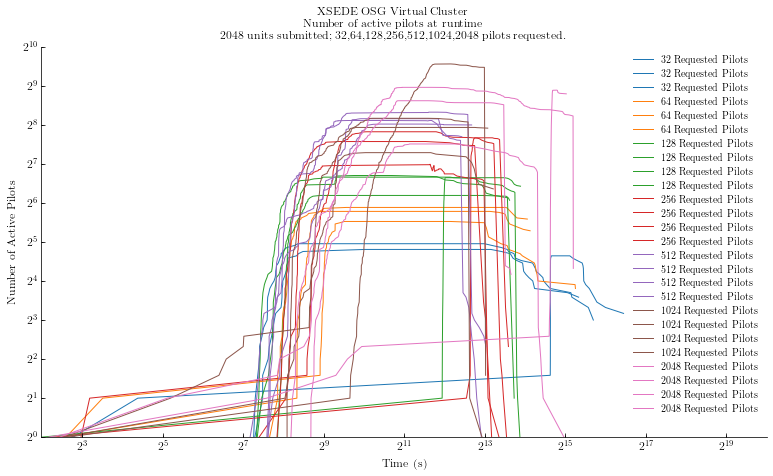

In [54]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots at runtime\n'+\
'2048 units submitted; 32,64,128,256,512,1024,2048 pilots requested.'
fig.suptitle(title)

color = 0
for s in sorted(sras.keys()):
    for s1 in sras[s]:
        # Broken session: open ticket.
        if s1._sid == 'rp.session.radical.mturilli.017131.0005':
            continue
        sc = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
        x = [item[0] for item in sc]
        y = [item[1] for item in sc]
        ax.plot(x, y, color=tableau20[color], label='%s Requested Pilots' % s)
    color = color + 2

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots')
# ax.set_xlim(0,17000)
ax.set_xlim(0,2**20)
ax.legend(numpoints=1)

# plt.savefig('figures/osg_nactive-concurrent-pilots.pdf', dpi=600, bbox_inches='tight')

In [55]:
# fig, ax = fig_setup()

# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.serif']  = ['Helvetica']
# mpl.rcParams['font.weight'] = 'bold'

# mpl.rcParams['legend.frameon'] = False
# mpl.rcParams['patch.linewidth'] = 2

# SIZE = 30
# plt.rc('font', size=SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
# plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=SIZE)  # legend fontsize
# plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# mpl.rcParams['lines.linewidth'] = 4
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

# # title='XSEDE OSG Virtual Cluster\n'+\
# # 'Number of active pilots at runtime\n'+\
# # '2048 units submitted; 32,64,128,256,512,1024,2048 pilots requested.'
# # fig.suptitle(title)

# color = 0
# for s in sorted(sras.keys()):
#     for s1 in sras[s]:
#         # Broken session: open ticket.
#         if s1._sid == 'rp.session.radical.mturilli.017131.0005':
#             continue
#         sc = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
#         x = [item[0] for item in sc]
#         y = [item[1] for item in sc]
#         ax.plot(x, y, color=tableau20[color], label='%s Requested Pilots' % s)
#     color = color + 2

# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
# plt.xlabel('Time (s)')
# plt.ylabel('Number of Active Pilots')
# # ax.set_xlim(0,17000)
# # ax.set_xlim(0,2**20)
# # ax.legend(numpoints=1)

# plt.savefig('figures/osg_nactive-concurrent-pilots-all.pdf', dpi=600, bbox_inches='tight')

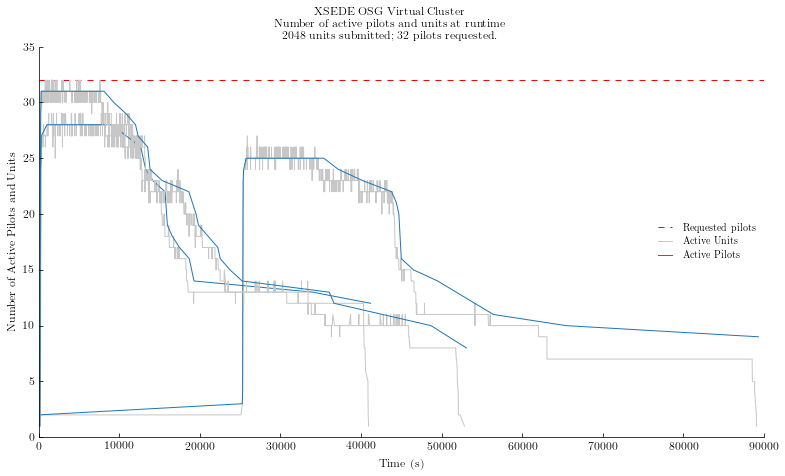

In [56]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 32 pilots requested.'
fig.suptitle(title)

ax.axhline(32, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[32]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005':
        continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[0])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

plt.savefig('figures/osg_nactive-concurrent-pilots_32.pdf', dpi=600, bbox_inches='tight')

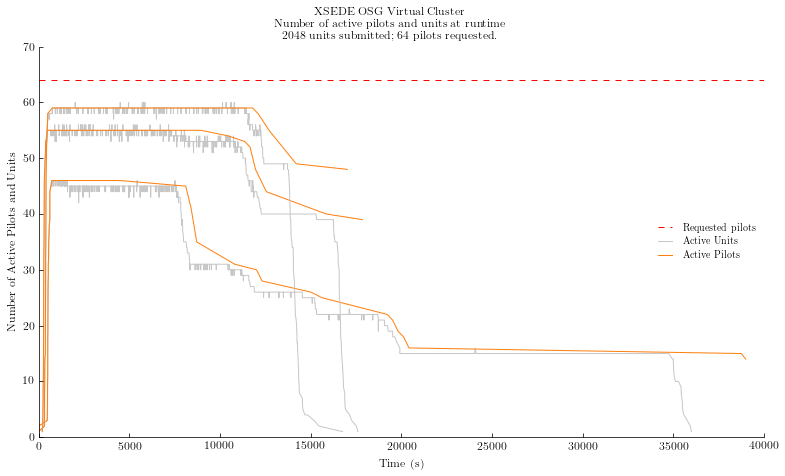

In [57]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 64 pilots requested.'
fig.suptitle(title)

ax.axhline(64, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[64]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005':
        continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[2])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [58]:
# fig, ax = fig_setup()

# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.serif']  = ['Helvetica']

# mpl.rcParams['legend.frameon'] = False
# mpl.rcParams['patch.linewidth'] = 0.75

# SIZE = 20
# plt.rc('font', size=SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
# plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=13)  # legend fontsize
# plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# # title='XSEDE OSG Virtual Cluster\n'+\
# # 'Number of active pilots and units at runtime\n'+\
# # '2048 units submitted; 64 pilots requested.'
# # fig.suptitle(title)

# ax.axhline(64, color='r', linestyle='dashed', linewidth=1)

# for s1 in sras[64]:
#     # Broken session: open ticket.
#     if s1._sid == 'rp.session.radical.mturilli.017131.0005':
#         continue
    
#     # Plot concurrent active units
#     scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
#     x = [item[0] for item in scu]
#     y = [item[1] for item in scu]
#     ax.plot(x, y, color=tableau20[23])
    
#     # Plot concurrent active pilots
#     scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
#     x = [item[0] for item in scp]
#     y = [item[1] for item in scp]
#     ax.plot(x, y, color=tableau20[2])
        
# # ax.set_xscale('log', basex=2)
# # ax.set_yscale('log', basey=2)
# plt.xlabel('Time (s)')
# plt.ylabel('Number of Active Pilots and Units')
# # ax.set_xlim(0,17000)
# # ax.set_ylim(0,130)
# ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

# plt.savefig('figures/osg_nactive-concurrent-pilots_64_direct.pdf', dpi=600, bbox_inches='tight')

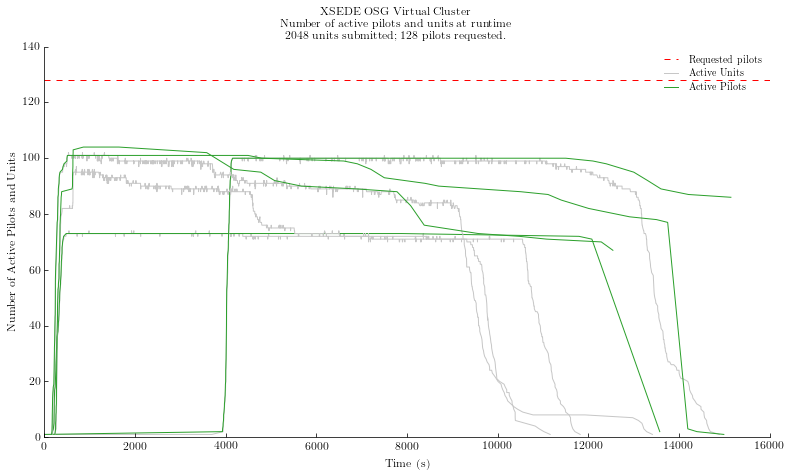

In [59]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 128 pilots requested.'
fig.suptitle(title)

ax.axhline(128, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[128]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005':
        continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[4])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'])

plt.savefig('figures/osg_nactive-concurrent-pilots_128.pdf', dpi=600, bbox_inches='tight')

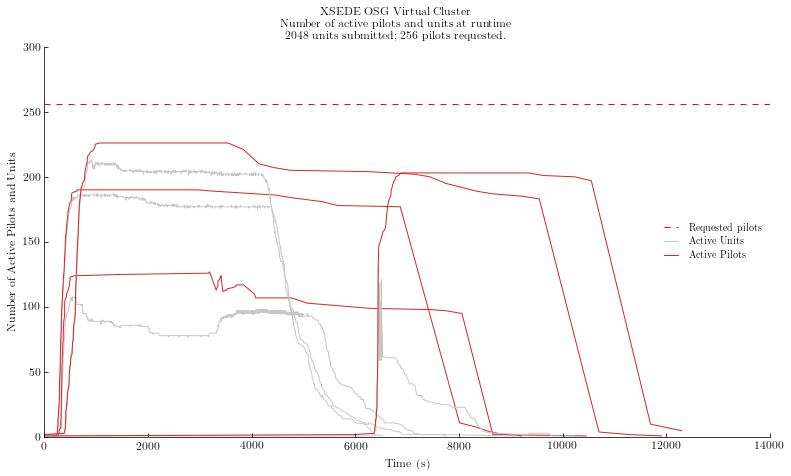

In [60]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 256 pilots requested.'
fig.suptitle(title)

ax.axhline(256, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[256]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005':
        continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[6])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

plt.savefig('figures/osg_nactive-concurrent-pilots_256.pdf', dpi=600, bbox_inches='tight')

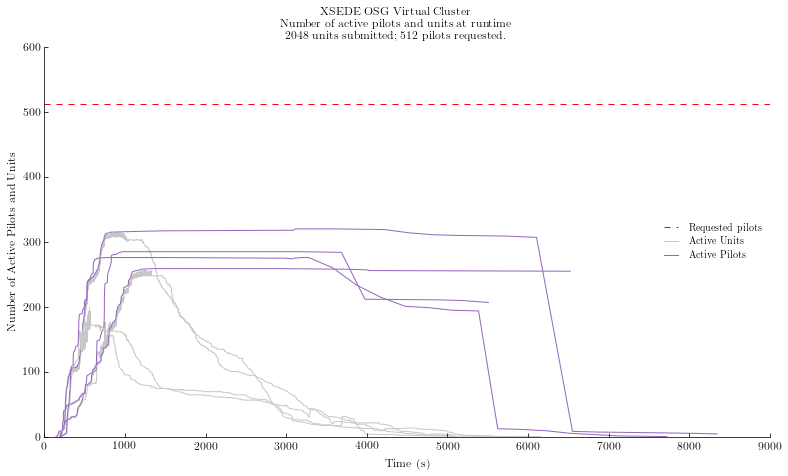

In [61]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 512 pilots requested.'
fig.suptitle(title)

ax.axhline(512, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[512]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005':
        continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[8])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

plt.savefig('figures/osg_nactive-concurrent-pilots_512.pdf', dpi=600, bbox_inches='tight')

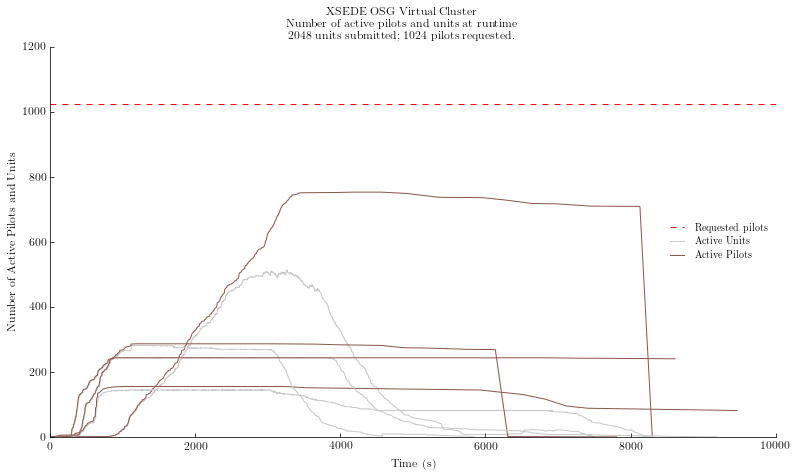

In [62]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 1024 pilots requested.'
fig.suptitle(title)

ax.axhline(1024, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[1024]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005':
        continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[10])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

plt.savefig('figures/osg_nactive-concurrent-pilots_1024.pdf', dpi=600, bbox_inches='tight')

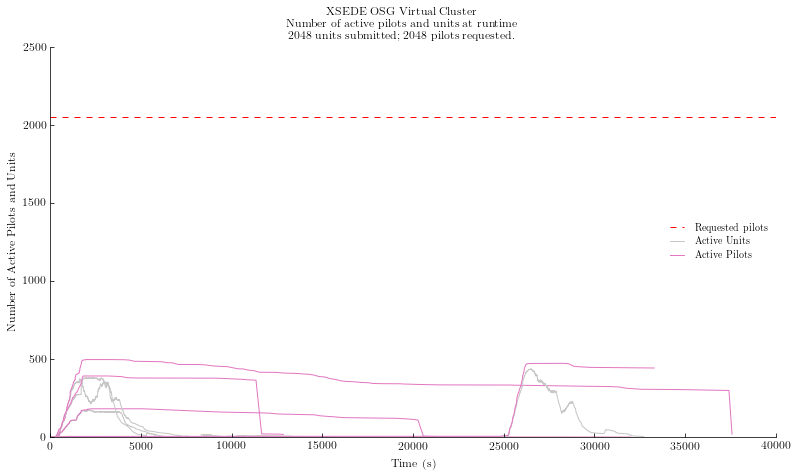

In [63]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 2048 pilots requested.'
fig.suptitle(title)

ax.axhline(2048, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[2048]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005':
        continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[12])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

plt.savefig('figures/osg_nactive-concurrent-pilots_2048.pdf', dpi=600, bbox_inches='tight')

## Conclusions

XOVC and OSG more in general have been introducing capabilities and tools to support the execution of both multithreaded and OpenMPI tasks up to 8 cores~\cite{}. Further, support for workload requiring GPUs, large dataset or large amount of memory is also beeing developed and deployed~\cite{}. These capabilities blur the traditional and by now obselete distinction between high performance computing (HPC) and high throughput computing (HTC), reinforcing the case for distributing workload executions across the diverse types of resources offered by XSEDE to its users. The work presented in this paper offer a methodological platform for the characterization of these new capabilities, studies that we plan to publish in dedicated future papers.  

## Acknoledgments
## References

----------------------------------------------------------
# NOTES AND TESTS - PLS IGNORE

In [64]:
display(units['U_AGENT_EXECUTING'].dropna().shape)
display(sessions['nunit_done'].sum())
pd.concat(
    [units.loc[units['U_AGENT_EXECUTING'].notnull()].groupby('sid').count()[['U_AGENT_EXECUTING']],
     sessions.loc[sessions['nunit_done'].isnull()]['nunit_done']], axis=1, join='inner')

(93759,)

93872

,U_AGENT_EXECUTING,nunit_done


In [65]:
# TODO: Number of requsted pilots Vs number of active pilots (x = sessions; y = integers)

In [66]:
# TODO: Number of unit rescheduled Vs TTC (x = TTC; y = number of units rescheduled)

In [67]:
# fig = plt.figure(figsize=(18,20))

# title = 'XSEDE OSG Virtual Cluster'
# subtitle = 'TTQ, TTR, TTX and TTC with Number of Active Pilots (black) and Number of Unique Resources (red)'
# fig.suptitle('%s:\n%s.' % (title, subtitle), fontsize=16)

# defs = {'ttq': 'TTQ = Total Time Queuing pilots',
#         'ttr': 'TTR = Total Time Running pilots',
#         'ttx': 'TTR = Total Time Executing compute units',
#         'ttc': 'TTC = Total Time Completing experiment run'}
# defslist = '%s;\n%s;\n%s;\n%s.' % (defs['ttq'], defs['ttr'], defs['ttx'], defs['ttc'])
# plt.figtext(.38,.89, defslist, fontsize=14, ha='left')

# gs = []
# grid  = gridspec.GridSpec(3, 2)
# grid.update(wspace=0.4, hspace=0.4, top=0.825)
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=grid[4]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[5]))

# ttq_subplots = []
# for exp in sessions['experiment'].sort_values().unique():
#     for nun in sessions['nunit_requested'].sort_values().unique():
#         if not sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun)].empty:
#             ttq_subplots.append(sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun) ].sort_values('TTC'))

# colors = {'exp1': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp2': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp3': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp4': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp5': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp6': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]]}


# nun_exp = []
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp5']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp6']['nunit_requested'].sort_values().unique()))

# ax = []
# i  = 0
# while(i < len(ttq_subplots)):
#     for gn in range(6):
#         for gc in range(nun_exp[gn]):
#             session = ttq_subplots.pop(0)
#             experiment = session['experiment'].unique()[0]
#             ntasks = int(session['nunit'].unique()[0])
#             npilots = int(session[session['experiment'] == experiment]['npilot'][0])
#             repetitions = session.shape[0]
#             color = colors[experiment]
#             title = 'Exp. %s\n%s tasks\n%s pilots\n%s rep.' % (experiment[3], ntasks, npilots, repetitions)
            
#             if i == 0:
#                 ax.append(plt.Subplot(fig, gs[gn][0, gc]))
#             else:
#                 ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
#             session[['P_LRMS_QUEUING', 
#                      'P_LRMS_RUNNING',
#                      'U_AGENT_EXECUTING',
#                      'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
#             ax[i].spines["top"].set_visible(False)
#             ax[i].spines["right"].set_visible(False)
#             ax[i].get_xaxis().tick_bottom()
#             ax[i].get_yaxis().tick_left()
#             ax[i].set_xticklabels([])
#             ax[i].set_xlabel('Runs')
            
#             # Handle a bug that sets yticklabels to visible 
#             # for the last subplot.
#             if i == 7 or i == 16 or i == 28:
#                 plt.setp(ax[i].get_yticklabels(), visible=False)
#             else:
#                 ax[i].set_ylabel('Time (s)')
                
#             # Handle legens.
#             if i == 3 or i == 11:
#                 ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
#             elif i == 23:
#                 ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(3.25, 1))
#             else:
#                 ax[i].get_legend().set_visible(False)
                
#             # Add labels.
#             rects = ax[i].patches
#             label_np = [int(l) for l in session['npilot_active']]
#             label_nh = [int(l) for l in session['nhost']]
#             nh = [r.get_height() for r in rects]
#             n = len(nh)/4              # Number of groups of 4 stacked bars
#             # partition the list of heights nh into number of bars n partitions;
#             # zip partitions into tuples t of n stacked bars;
#             # sum eacth tuple into the hight of n stacked bars.
#             heights = [sum(t) for t in zip(*[nh[j:j + n] for j in xrange(0, len(nh), n)])]
            
#             # Add labels with number of pilots requested per session.
#             for rect, label, height in zip(rects[-repetitions:], label_np, heights):
#                 ax[i].text(rect.get_x() + rect.get_width()/2, 
#                            height+3500, label, ha='center', va='bottom')
            
#             # Add labels with number of unique resources per session.
#             for rect, label, height in zip(rects[-repetitions:], label_nh, heights):
#                 ax[i].text(rect.get_x() + rect.get_width()/2, 
#                            height+500, label, ha='center', va='bottom', color='red')

#             fig.add_subplot(ax[i])
#             i += 1
            
# plt.savefig('figures/osg_experiment_comparison.pdf', dpi=600, bbox_inches='tight')

# Analysis Total Unit Execution Time ($TTX$)

# Analysis Total Pilot Queuing Time ($TTQ$)

# Analysis Unit Execution Time ($T_x$)

In [68]:
units['U_AGENT_EXECUTING'].dropna().describe()

count    93759.000000
mean       450.184340
std        317.650246
min        120.365900
25%        269.340650
50%        361.278700
75%        504.600450
max       5545.682500
Name: U_AGENT_EXECUTING, dtype: float64

## Distribution of $T_x$

## Comparison of the Distribution of $T_x$ per Experiment

## Comparison of the Distribution of Six Shuffled Partitions of the Set of Units

In [69]:
from random import shuffle

txd_exp1 = units[units['experiment'].str.contains('exp1')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp2 = units[units['experiment'].str.contains('exp2')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp3 = units[units['experiment'].str.contains('exp3')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp4 = units[units['experiment'].str.contains('exp4')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp5 = units[units['experiment'].str.contains('exp5')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp6 = units[units['experiment'].str.contains('exp6')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp7 = units[units['experiment'].str.contains('exp7')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp8 = units[units['experiment'].str.contains('exp8')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp9 = units[units['experiment'].str.contains('exp9')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

txd_all = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

ntx = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).count()
txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)

# Partions with 1/4 elements of the total set of units.
txd_shf1 = txd_shuffled[:6107].describe() 
txd_shf2 = txd_shuffled[6108:12215].describe()
txd_shf3 = txd_shuffled[12216:18323].describe()
txd_shf4 = txd_shuffled[18324:24431].describe()
txd_shf5 = txd_shuffled[24432:30540].describe()
txd_shf6 = txd_shuffled[30541:36648].describe()
txd_shf7 = txd_shuffled[36649:42756].describe()
txd_shf8 = txd_shuffled[42757:48864].describe()
txd_shf9 = txd_shuffled[48865:].describe()

tx_exp_descriptions = pd.DataFrame({'all' : txd_all,
                                    'exp1': txd_exp1,'exp2': txd_exp2,'exp3': txd_exp3,'exp4': txd_exp4,
                                    'exp5': txd_exp5,'exp6': txd_exp6,'exp7': txd_exp7,'exp8': txd_exp8,
                                    'exp9': txd_exp9,
                                    'shf1': txd_shf1,'shf2': txd_shf2,'shf3': txd_shf3,'shf4': txd_shf4,
                                    'shf5': txd_shf5,'shf6': txd_shf6,'shf7': txd_shf7,'shf8': txd_shf8,
                                    'shf9': txd_shf9})

tx_exp_descriptions

,all,exp1,exp2,exp3,exp4,exp5,exp6,exp7,exp8,exp9,shf1,shf2,shf3,shf4,shf5,shf6,shf7,shf8,shf9
count,93759.000000,40570.000000,0.0,0.0,992.000000,3960.000000,15706.000000,5657.000000,10898.000000,15976.000000,6107.000000,6107.000000,6107.000000,6107.000000,6108.000000,6107.000000,6107.000000,6107.000000,44894.000000
mean,450.184340,450.565968,NaN,NaN,363.009487,384.034253,440.323678,581.454594,479.266835,414.398403,447.515747,453.233285,448.873212,456.909899,451.740891,447.097796,447.262275,448.050854,450.274329
std,317.650246,289.507041,NaN,NaN,134.266899,208.181846,265.823951,514.864512,427.995906,263.820209,312.426915,313.241861,319.499162,322.088322,321.950523,316.443131,308.925063,318.543261,318.725642
min,120.365900,129.190900,NaN,NaN,170.191000,133.432300,120.365900,134.133300,128.124900,159.096200,126.265400,131.996400,129.731300,130.157400,128.916400,125.473300,128.124900,130.129000,120.365900
25%,269.340650,287.392150,NaN,NaN,282.287225,209.223325,253.522650,246.511800,239.295625,251.687600,267.264850,272.433300,267.270100,273.032600,269.175050,265.567850,270.266050,270.268400,270.268300
50%,361.278700,377.513200,NaN,NaN,345.135050,357.587600,384.393900,360.379800,326.381050,331.262650,355.678500,367.388000,356.795900,366.406700,361.663900,359.936200,361.791100,360.088300,361.344250
75%,504.600450,499.504400,NaN,NaN,424.428400,473.506550,559.558900,766.763000,543.912700,483.752400,504.544700,513.513250,504.780650,510.729950,506.050100,499.278750,503.430950,501.501800,504.499575
max,5545.682500,5340.270100,NaN,NaN,1382.527900,2216.327500,4135.194400,5545.682500,4880.923500,3791.195500,4598.029800,4406.605300,5442.668400,4880.923500,5079.101700,5309.456100,5410.618500,5545.682500,5340.270100


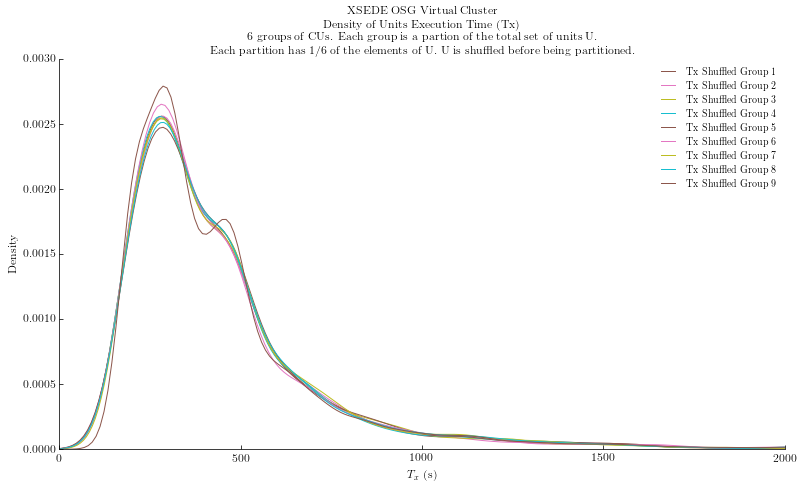

In [70]:
fig, ax = fig_setup()
resource = 'XSEDE OSG Virtual Cluster'
description = 'Density of Units Execution Time (Tx)'
explanation1 = '6 groups of CUs. Each group is a partion of the total set of units U'
explanation2 = 'Each partition has 1/6 of the elements of U. U is shuffled before being partitioned'
title='%s\n%s\n%s.\n%s.' % (resource, description, explanation1, explanation2)

txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)
txd_shf1 = txd_shuffled[:6107].reset_index(drop=True).tolist()
txd_shf2 = txd_shuffled[6108:12215].reset_index(drop=True).tolist()
txd_shf3 = txd_shuffled[12216:18323].reset_index(drop=True).tolist()
txd_shf4 = txd_shuffled[18324:24431].reset_index(drop=True).tolist()
txd_shf5 = txd_shuffled[24432:30540].reset_index(drop=True).tolist()
txd_shf6 = txd_shuffled[30541:36648].reset_index(drop=True).tolist()
txd_shf7 = txd_shuffled[36649:42756].reset_index(drop=True).tolist()
txd_shf8 = txd_shuffled[42757:48864].reset_index(drop=True).tolist()
txd_shf9 = txd_shuffled[48865:].reset_index(drop=True).tolist()

df_shf1 = pd.DataFrame(txd_shf1, columns=['shf1'])
df_shf2 = pd.DataFrame(txd_shf2, columns=['shf2'])
df_shf3 = pd.DataFrame(txd_shf3, columns=['shf3'])
df_shf4 = pd.DataFrame(txd_shf4, columns=['shf4'])
df_shf5 = pd.DataFrame(txd_shf5, columns=['shf6'])
df_shf6 = pd.DataFrame(txd_shf6, columns=['shf6'])
df_shf7 = pd.DataFrame(txd_shf7, columns=['shf7'])
df_shf8 = pd.DataFrame(txd_shf8, columns=['shf8'])
df_shf9 = pd.DataFrame(txd_shf9, columns=['shf9'])

# txd_shfs = pd.concat([df_exp1, df_exp2, df_exp3, df_exp4, 
#                       df_shf1, df_shf2, df_shf3, df_shf4], join='outer', axis=1)
txd_shfs = pd.concat([df_shf1, df_shf2, df_shf3, 
                      df_shf4, df_shf5, df_shf6,
                      df_shf7, df_shf8, df_shf9,], join='outer', axis=1)

# txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[0], tableau20[2], tableau20[8], tableau20[4],
#                                                  tableau20[10],tableau20[12],tableau20[14],tableau20[16]])
txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[10],tableau20[12],tableau20[14],tableau20[16]])

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')

ax.legend(labels=['Tx Shuffled Group 1','Tx Shuffled Group 2',
                  'Tx Shuffled Group 3','Tx Shuffled Group 4',
                  'Tx Shuffled Group 5','Tx Shuffled Group 6',
                  'Tx Shuffled Group 7','Tx Shuffled Group 8',
                  'Tx Shuffled Group 9'])

plt.savefig('figures/osg_tx_shuffled_frequency.pdf', dpi=600, bbox_inches='tight')

# $T_x$ as Function of Resource Heterogeneity

In [71]:
us = units

top10hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:10].index.tolist()
top08hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:8].index.tolist()
tophost = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:1].index.tolist()

# display(us['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top10hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top08hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(tophost)]['U_AGENT_EXECUTING'].dropna().describe())

us[us['U_AGENT_EXECUTING'] <= 0.4]


,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,U_UMGR_BINDING,U_UMGR_SCHEDULING,experiment,hid,pid,sid,uid


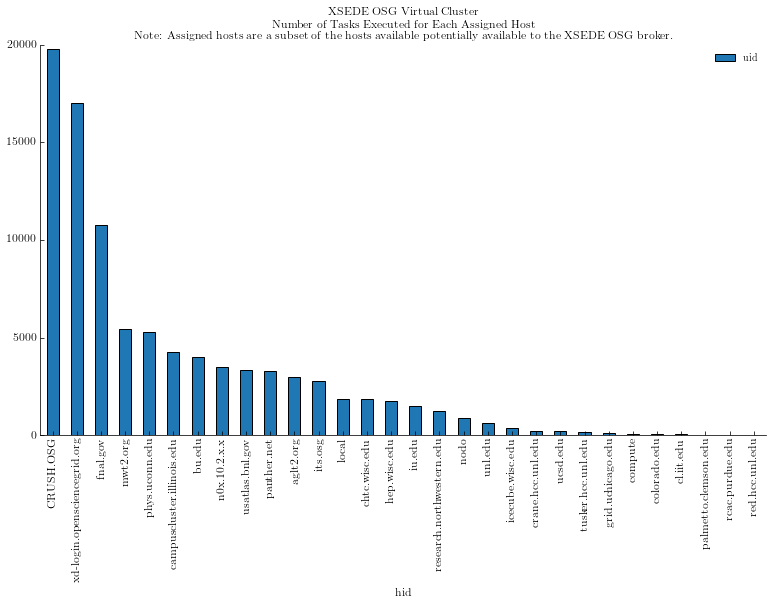

In [72]:
# TODO: Number of successful Task executions per host (x = hosts; y = number of executed tasks)

fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].notnull()]
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

#plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

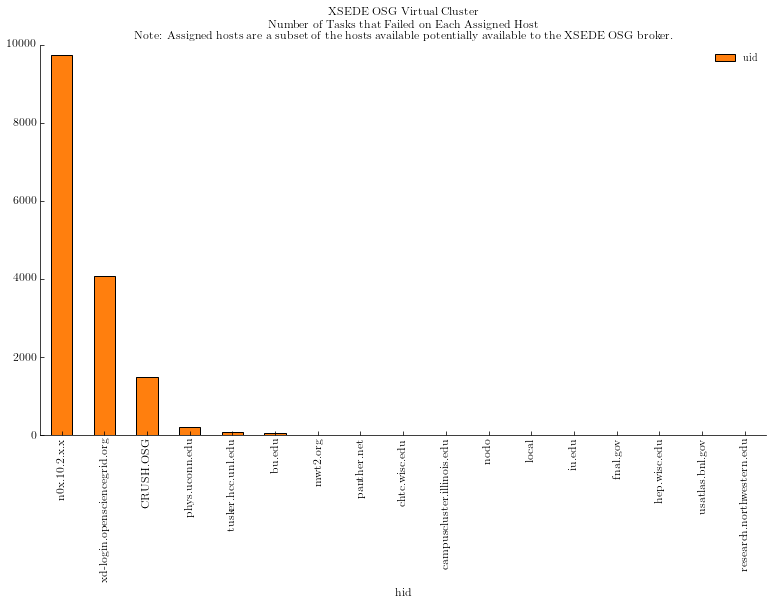

In [73]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks that Failed on Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].isnull()]
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[2], title=title)

plt.savefig('figures/osg_nunits_failed_per_host.pdf', dpi=600, bbox_inches='tight')

In [74]:
# s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist()
#s[0:1]

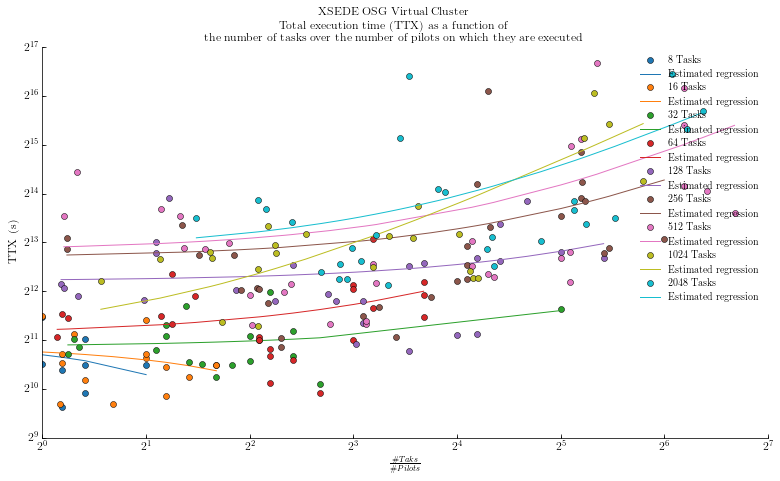

In [75]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    x = s[s['nunit_requested']==u]['NuOnNpActive'].dropna().sort_values().copy()
    y = s[s['nunit_requested']==u]['U_AGENT_EXECUTING'].dropna().copy()
    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit)
    c = colors.pop(0)

    ax.plot(x, y, marker='o', linestyle='', label='%s Tasks' % u, color=c)
    ax.plot(x, fit_fn(x), color=c, label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots_by_bot-size.pdf', dpi=600, bbox_inches='tight')

In [76]:
pilots[(pilots['sid'] == 'rp.session.radical.mturilli.017134.0002') &
       (pilots['pid'] == 'pilot.0013')]['hid'].tolist()

['CRUSH.OSG']